In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results_cpp_benchmarker/e2e_results/image_driver_1')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results_cpp_benchmarker/e2e_results/image_driver_1


In [39]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["throughput_results"]
    result = {}
    def carefully_merge_dicts(lst, reconcile_function=None):
        result = {}
        for d in lst:
            assert reconcile_function != None or len(list(set(result) & set(d))) == 0, "Merging dictionaries will lead to overwriting: {}".format(list(set(result) & set(d)))
            result.update(d)
        return result
    def append_merge_dicts(lst):
        result = {}
        for dictionary in lst:
            for k,v in dictionary.iteritems():
                if k in result.keys():
                    result[k] = np.concatenate([result[k], v], axis=0)
                else:
                    result[k] = np.squeeze([v])
        return result
    def extract_queue_sizes(data_lists):
        local_result = carefully_merge_dicts(data_lists)
        for k,v in local_result.iteritems():
            local_result[k] = np.asarray([[k_,v_] for k_,v_ in carefully_merge_dicts(v["items"], max).iteritems()]).astype(int)
        return local_result
    result = append_merge_dicts([extract_queue_sizes(x["data_lists"]) for x in all_metrics["clipper_metrics"]])
#         for item in data_lists:
#             key = item.keys()[0]
#             key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
#             if result.get(key) == None:
#                 result[key] = []
#             if timestamps:
#                 data = item[key]["items"]
#                 data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
#                 value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
#             else:
#                 value = np.asarray(item[key]["items"]).astype(float)
#                 value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
#             result[key].append(value)
#     import re
#     client_timestamps = {}
#     for k,v in d["client_metrics"][0].iteritems():
#         if re.compile(".+->.+_timestamps").match(k):
#             client_timestamps[str(k)] = np.asarray(v)     
#     batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
#     for key, value in result.iteritems():
#         result[key] = np.concatenate(value)
#     hollistic_data = {}
#     mean_batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
#     mean_batchsizes_final = {}
#     for dictionary in mean_batch_sizes:
#         keys_a = set(dictionary.keys())
#         keys_b = set(mean_batchsizes_final.keys())
#         intersection = keys_a & keys_b
#         just_in_dictionary = keys_a - keys_b
#         for key in intersection:
#             mean_batchsizes_final[key].append(dictionary[key])
#         for key in just_in_dictionary:
#             mean_batchsizes_final[key] = [dictionary[key]]
#     hollistic_data["mean_batch_sizes"] = mean_batchsizes_final
#     str_lats = d["client_metrics"][0]["all_lats"]
#     import ast
#     lats = [ast.literal_eval(x) for x in str_lats]
#     hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
#     hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
#     hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
#     hollistic_data["client_timestamps"] = client_timestamps
    
#     used_delay = d["client_metrics"][0]["used_delay"].split("|")
#     hollistic_data["used_delay_process"] = used_delay[0]
#     hollistic_data["used_delay_batchsize"] = used_delay[1]
#     hollistic_data["used_delay_value"] = used_delay[2]
    return result#, hollistic_data

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

half_image_driver_1_models = [
    "tf-resnet-feats",
    "inception"
]

ID1 = cache_extractions(HOME+"/"+"cpp-aws-p2-1-inception-1-resnet-3-ksvm-1-logreg-180326_230949.json", timestamps=True)

def clean_extraction(extraction):
    # taking off the first 5% of the records to be sure the warmup time is removed
    for key, value in extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        extraction[key] = value[value.shape[0]/20:] # cut off the first fourth from warmup effects

clean_extraction(ID1)
        
for key, value in ID1.iteritems():
    print key, value.shape

tf-log-reg:1:queue_sizes (76000, 2)
model:tf-resnet-feats:1:batch_size (9137, 2)
model:inception:1:batch_size (22804, 2)
tf-kernel-svm:1:queue_sizes (61406, 2)
tf-resnet-feats:1:queue_sizes (47132, 2)
model:tf-log-reg:1:batch_size (38011, 2)
inception:1:queue_sizes (60809, 2)
model:tf-kernel-svm:1:batch_size (23371, 2)


In [338]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.01)

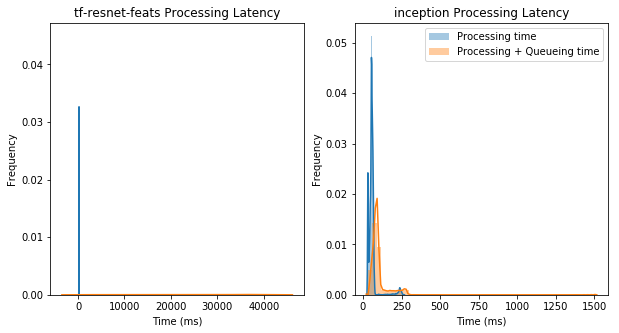

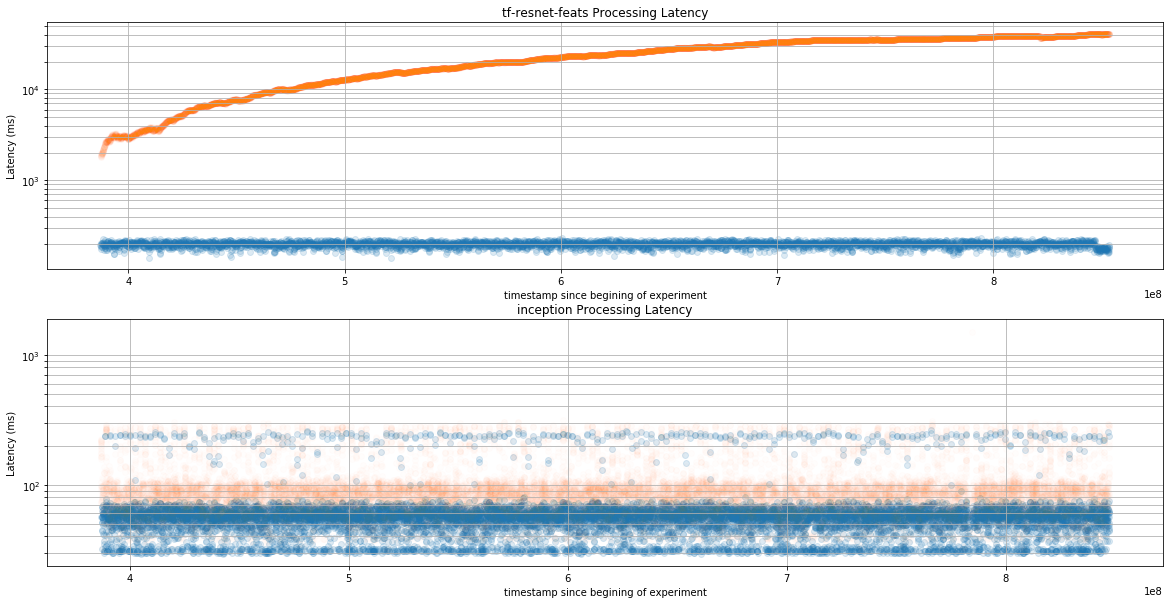

In [339]:
compare_latency_dists(half_ID1_500, half_image_driver_1_models)
compare_latency_dists_over_time(half_ID1_500, half_image_driver_1_models)

In [10]:
def get_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        intervals, _ = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        smoothLineHistogram(intervals, label=model+str(" CV="+str(CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        intervals, timestamps = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([np.min(intervals), np.max(intervals)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, intervals, label="CV="+str(CV), alpha = 0.3)
        plt.legend()
    plt.show()


In [ ]:
plot_inter_arrival_over_time(ID1_500, image_driver_1_models, intra_batch_arrivals=True)
plot_inter_arrival(ID1_500, image_driver_1_models, intra_batch_arrivals=True)

In [41]:
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]/1000000.
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

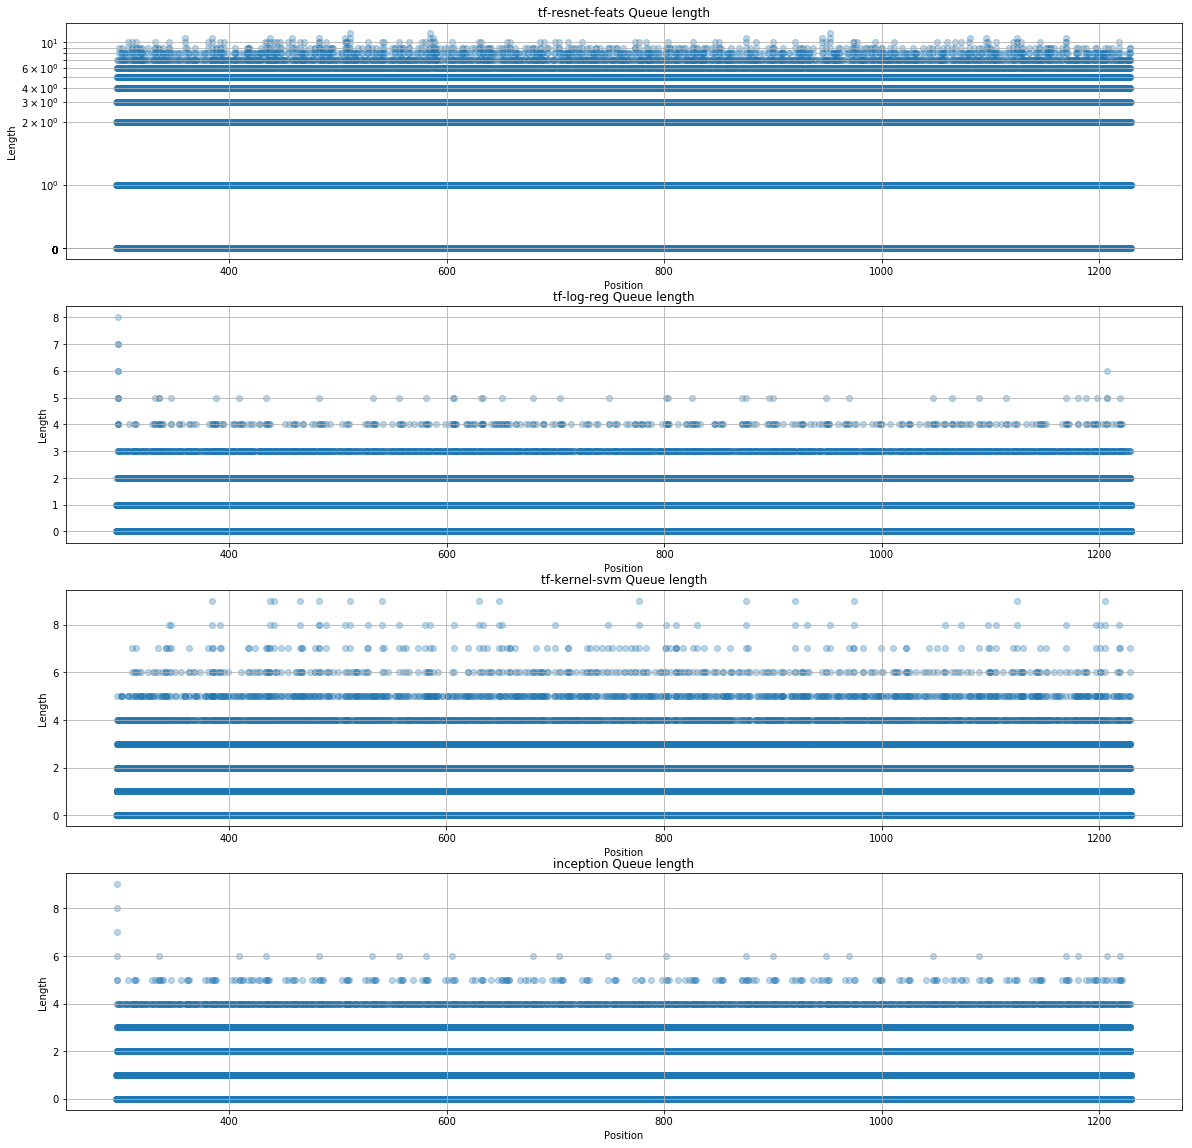

In [10]:
plot_ordinal_queue_sizes(ID1, image_driver_1_models)

In [46]:
def plot_ordinal_batch_size(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions["model:"+model+":1:batch_size"][:,1]
        timestamps = cached_extractions["model:"+model+":1:batch_size"][:,0]/1000000.
        plt.title(model+" Batch size")
        plt.xlabel("Position")
        plt.ylabel("Batch size")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

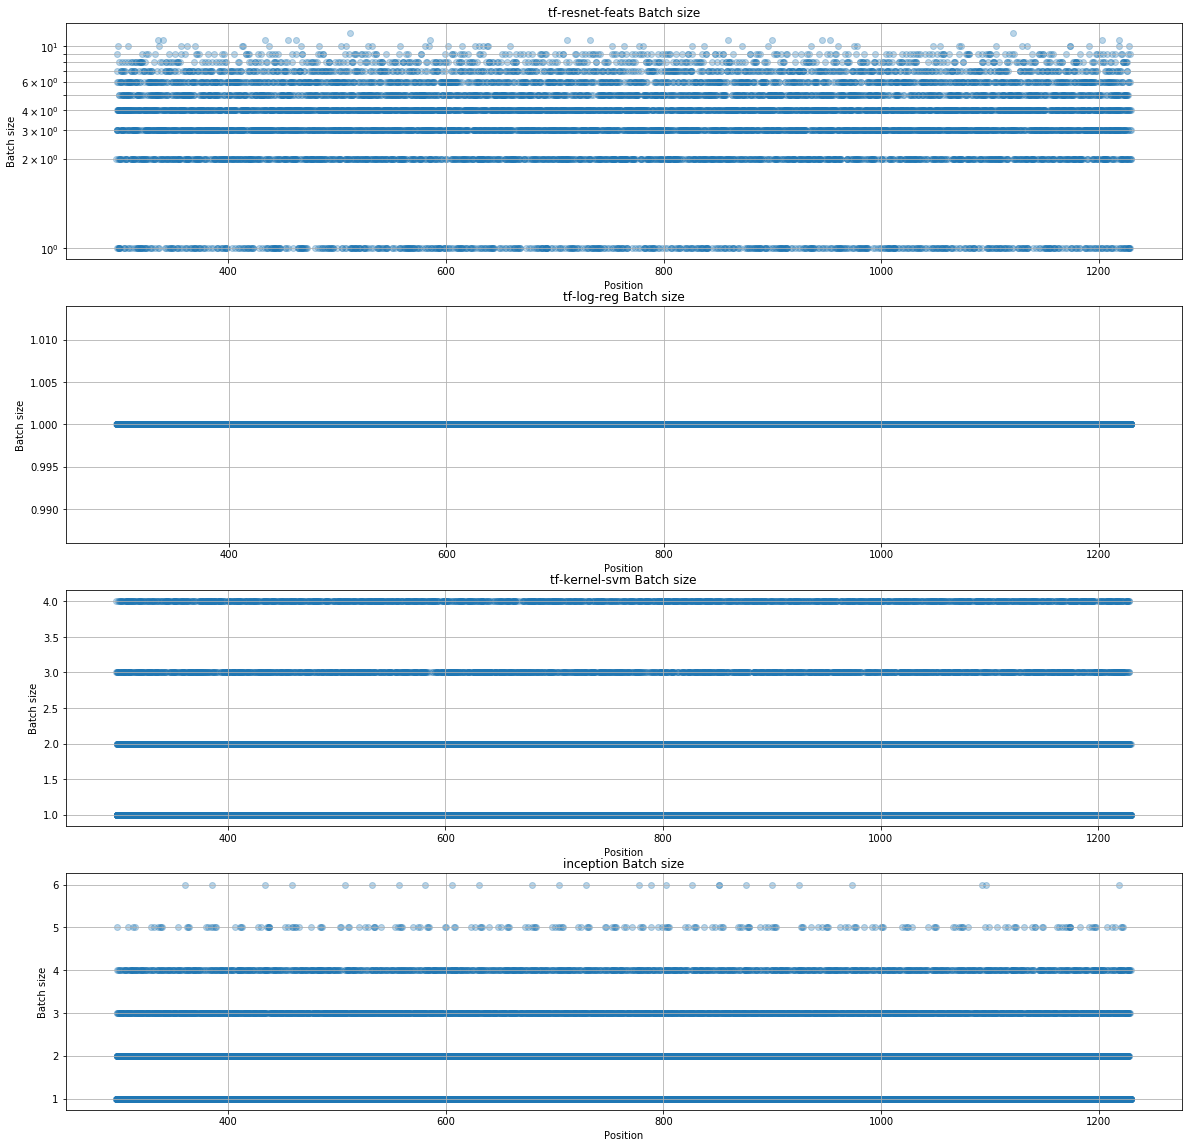

In [47]:
plot_ordinal_batch_size(ID1, image_driver_1_models)

In [16]:
def get_max_curve(timestamps, trial_range):
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
    y_axis = np.asarray([get_smallest_delta_2(float(i), timestamps) for i in trial_range])
    x_axis = np.asarray(list(trial_range))
    return x_axis, y_axis

In [26]:
x_range = np.linspace(1,2000,200)
with open('../../array.txt') as f:
    lines = f.read().splitlines()
lines = [x.rstrip() for x in lines]
lines = np.cumsum(np.asarray(lines).astype(float))
x, y = get_max_curve(lines, x_range)

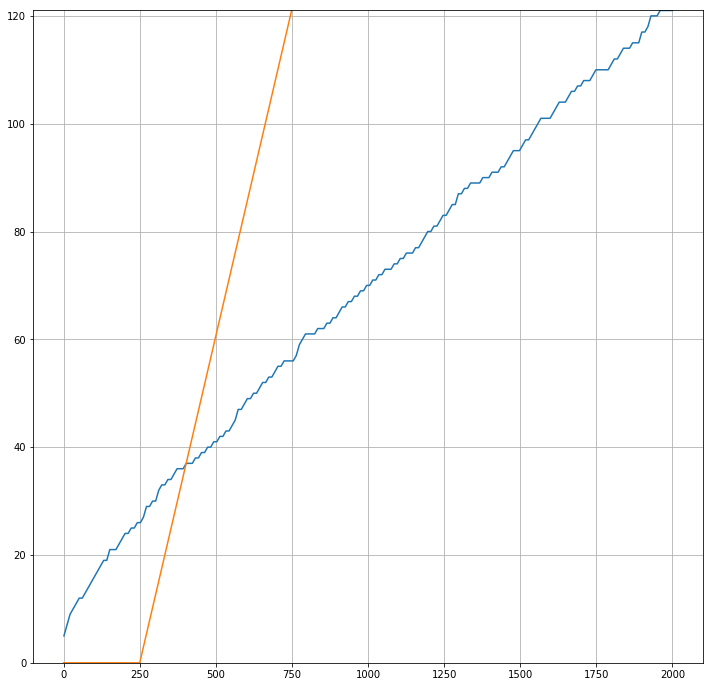

In [49]:
x_range = np.linspace(1,2000,200)
plt.figure(figsize=(12,12))
plt.ylim([0,max(y)])
plt.plot(x,y)
service_latency = 250
plt.plot([0,service_latency,max(x_range)], [0,0,(max(x_range)-service_latency)/1000*242.48075285714285])
plt.grid(True)

In [302]:
[(k, len(v)) for k,v in ID1_500_hollistic["client_timestamps"].iteritems()]

[('start->tf-resnet-feats_timestamps', 20000),
 ('inception->tf-log-reg_timestamps', 19996),
 ('start->inception_timestamps', 20000),
 ('tf-kernel-svm->join_timestamps', 19998),
 ('join->end_timestamps', 19995),
 ('tf-log-reg->join_timestamps', 19995),
 ('tf-resnet-feats->tf-kernel-svm_timestamps', 19999)]

In [57]:
x_range = xrange(1,90002,400)
resnet_arrival = ID1_500_hollistic["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
resnet_departure = ID1_500_hollistic["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet, y_arrival_resnet = get_max_curve(resnet_arrival, x_range)
x_departure_resnet, y_departure_resnet = get_max_curve(resnet_departure, x_range)

In [221]:
x_range = xrange(1,45002,200)
resnet_arrival_clipper = ID1_500["tf-resnet-feats:1:queue_arrivals"][:,0]/1000.
x_arrival_resnet_clipper, y_arrival_resnet_clipper = get_max_curve(resnet_arrival_clipper, x_range)

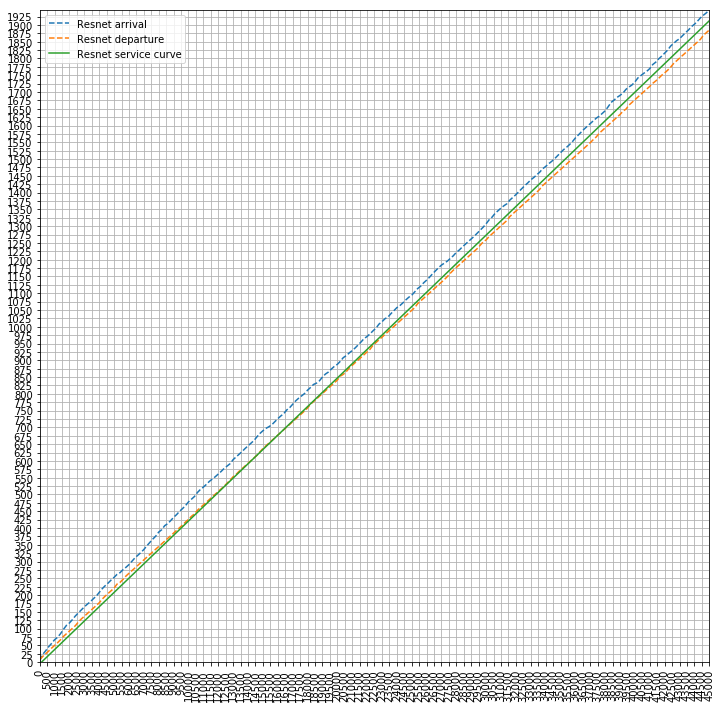

In [277]:
plt.figure(figsize=(12,12))
x_jump = 500
plt.xticks(xrange(0,max(x_range)+x_jump,x_jump))
plt.xticks(rotation=90)
plt.gca().set_ylim([0,y_arrival_resnet[-1]])
plt.yticks(xrange(0,y_arrival_resnet[-1],25))
plt.grid(True)
plt.xlim([0,45000])
# plt.ylim([0,220])
plt.plot(x_arrival_resnet, y_arrival_resnet, label="Resnet arrival", linestyle="--")
# plt.plot(x_arrival_resnet_clipper, y_arrival_resnet_clipper, label="Resnet arrival clipper", linestyle="--")
plt.plot(x_departure_resnet, y_departure_resnet, label="Resnet departure", linestyle="--")
plt.plot([0,120,max(x_range)],[0,0,max(x_range)/1000.*42.5], label="Resnet service curve")
# plt.plot([0,100,max(x_range)],[0,0,max(x_range)/1000.*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()

In [59]:
def get_max_service_time(x_values, y_values, service_latency, service_throughput):
    largest_gap = 0
    for x_value, y_value in zip(x_values, y_values):
        service_x = y_value/service_throughput + service_latency
        if service_x - x_value > largest_gap:
            largest_gap = service_x - x_value
    return largest_gap

def get_max_queue_size(x_values, y_values, service_latency, service_throughput):
    largest_gap = 0
    for x_value, y_value in zip(x_values, y_values):
        service_y = 0 if x_value < service_latency else (x_value-service_latency)*float(service_throughput)
        if y_value - service_y > largest_gap:
            largest_gap = y_value - service_y
    return largest_gap

In [62]:
print get_max_service_time(x_arrival_resnet, y_arrival_resnet, 200, 43./1000.)
print get_max_queue_size(x_arrival_resnet, y_arrival_resnet, 200, 43./1000.)

1375.74418605
59.157


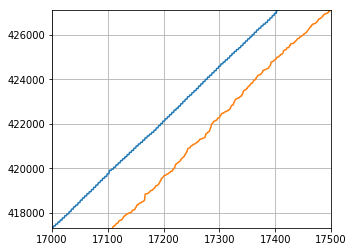

In [78]:
plt.plot(resnet_departure)
plt.plot(resnet_arrival[:-1])
plt.xlim([17000,17500])
plt.ylim([resnet_departure[17000],resnet_arrival[17500]])
plt.grid(True)

In [228]:
#Handle times go here

In [285]:
resnet_loop_times = np.asarray([31, 631543, 85797, 119451, 101828, 82794, 83797, 106280, 107389, 103421, 96873, 102720, 105229, 100057, 83081, 98017, 87793, 97990, 104542, 100147, 105217, 96186, 102670, 88838, 102926, 109917, 90254, 98711, 84060, 85863, 101149, 103962, 84733, 99163, 100211, 100010, 95175, 94804, 100737, 88739, 102499, 110333, 97922, 97516, 100541, 98929, 101294, 97472, 106236, 106257, 87392, 82662, 100449, 105108, 85773, 101472, 96086, 100026, 104828, 102218, 100738, 103547, 97480, 100770, 99675, 97905, 86503, 108038, 103854, 103577, 101339, 98378, 108531, 97378, 100003, 100852, 102614, 86557, 92334, 110301, 101600, 106182, 99907, 100269, 104117, 92186, 85019, 100217, 87555, 101154, 111439, 103611, 78068, 95326, 84905, 102516, 76604, 103068, 100335, 87836, 86209, 101824, 102498, 101644, 100433, 78679, 99379, 99146, 108441, 102748, 103800, 108510, 96566, 103605, 106896, 86123, 100759, 83126, 99574, 110819, 101288, 106966, 97300, 101301, 101552, 107229, 99040, 103131, 109382, 86324, 105158, 102171, 84834, 102114, 108590, 108211, 107290, 83942, 89425, 110952, 108111, 87932, 86775, 105874, 83826, 99743, 105134, 105698, 85072, 95395, 104294, 109794, 104406, 100745, 105553, 106290, 104591, 105941, 114053, 110307, 103623, 107687, 101579, 100434, 104529, 110846, 102755, 101581, 109142, 104959, 108726, 103503, 103552, 107184, 109139, 99263, 108082, 90144, 107023, 102307, 104344, 110851, 86983, 106593, 84973, 103640, 85592, 97884, 98959, 102447, 103033, 90955, 98246, 106217, 110979, 103390, 83017, 108390, 103840, 98081, 84453, 87235, 108995, 104816, 107040, 103418, 89036, 102185, 103089, 102437, 87196, 83128, 107176, 105171, 90703, 100748, 102492, 85186, 104699, 104000, 87314, 84830, 106128, 101682, 98501, 84724, 81974, 101303, 97266, 102899, 91956, 102175, 84396, 104190, 106423, 83162, 102817, 87084, 100068, 87247, 103697, 102142, 107013, 104519, 108080, 104217, 100042, 93156, 101653, 109677, 113236, 93678, 106270, 104227, 109652, 89286, 104916, 105891, 103180, 99089, 111435, 86392, 86608, 85563, 108298, 101757, 99496, 100430, 87569, 81315, 108203, 95239, 106630, 83821, 105885, 107201, 106373, 105014, 96989, 107362, 83816, 102319, 87429, 107730, 99447, 85631, 95008, 84973, 98547, 97420, 78825, 109560, 105228, 105768, 106148, 104687, 78922, 104789, 88370, 104807, 104199, 97759, 100779, 105710, 83003, 93467, 97893, 99585, 111508, 109847, 103913, 99404, 109585, 85241, 96357, 100372, 99935, 100230, 109906, 102753, 110271, 102697, 82928, 101650, 98374, 107227, 92361, 106110, 104220, 97725, 108666, 103731, 107635, 103050, 108508, 103610, 108505, 86376, 95373, 101820, 105886, 106575, 101642, 100427, 106752, 107977, 87653, 101696, 104326, 86144, 105086, 84097, 101649, 92603, 99520, 110727, 105474, 86516, 106006, 111514, 100172, 80416, 86745, 105727, 90918, 108820, 87412, 94403, 78356, 90016, 105079, 100301, 101458, 83812, 99821, 93070, 99710, 100930, 106836, 96650, 89938, 102901, 103501, 81435, 96414, 90720, 102830, 90619, 82703, 101990, 104581, 103637, 84382, 87388, 84019, 99266, 105388, 85247, 85565, 100809, 99916, 108713, 99550, 112346, 101026, 91118, 110226, 103119, 97406, 94318, 102110, 103990, 103965, 94975, 95627, 108352, 100459, 111486, 102316, 82483, 81396, 107348, 98050, 103644, 110188, 85502, 109975, 102899, 98498, 105465, 108953, 102768, 101923, 99726, 102479, 100414, 111557, 104201, 101227, 99507, 105167, 106350, 103306, 105631, 102170, 86063, 101194, 102529, 99922, 96576, 85735, 103819, 99176, 103088, 89222, 106986, 99629, 105791, 103700, 104187, 100836, 105144, 89720, 108153, 81976, 99973, 101400, 109641, 83963, 86949, 80316, 111628, 105103, 103667, 104530, 104231, 101112, 104812, 105952, 90571, 95281, 85393, 87137, 87441, 98747, 107830, 106846, 84978, 103777, 103451, 102261, 104721, 104149, 106637, 101772, 86212, 105849, 102757, 98994, 87781, 88430, 102703, 102915, 104648, 106384, 86151, 96400, 101249, 95715, 79828, 103777, 92689, 88638, 90844, 109963, 99969, 108331, 101714, 88287, 103817, 106128, 95775, 87605, 108153, 104204, 83704, 104778, 106517, 89807, 86722, 110598, 97521, 102356, 98666, 105762, 101402, 104110, 102733, 105992, 94440, 105044, 83767, 97489, 103281, 103824, 106355, 103208, 99020, 107362, 103529, 104417, 107375, 87789, 87919, 110571, 108064, 103937, 111319, 99602, 85562, 100827, 102040, 105427, 105217, 88502, 103607, 109961, 105674, 112440, 111616, 84665, 88445, 87249, 102505, 100699, 82869, 79359, 104230, 97274, 104550, 88626, 84307, 111220, 99408, 101346, 86644, 109275, 100052, 102532, 103965, 87899, 98191, 104308, 105451, 85633, 104173, 85344, 108300, 102381, 102379, 104458, 100580, 94313, 84583, 91506, 99668, 101497, 99839, 99190, 103543, 100066, 101731, 101385, 106589, 90911, 93960, 101896, 100839, 110284, 108124, 85498, 88389, 104603, 101952, 95588, 98602, 105649, 100092, 99785, 99867, 104525, 105297, 97970, 96201, 102697, 95827, 102721, 88466, 96273, 102853, 105262, 87128, 100213, 83291, 106949, 103070, 107182, 104478, 103630, 106958, 86535, 106851, 101394, 100641, 102898, 103366, 82381, 104341, 83814, 100348, 84378, 101485, 89794, 86731, 100926, 102680, 103427, 109041, 82799, 100746, 110001, 88615, 77982, 104717, 97728, 94674, 106042, 85051, 95794, 107701, 104494, 101465, 95139, 92268, 101142, 86246, 98076, 98188, 105313, 97210, 99764, 105658, 100355, 86423, 108279, 99096, 99844, 98920, 102001, 82913, 106313, 98002, 100417, 75296, 89991, 82495, 101535, 100040, 78108, 104012, 85348, 93298, 83898, 87886, 98631, 94128, 99852, 83630, 100147, 102402, 98916, 98564, 105553, 98516, 96059, 95636, 100098, 93524, 96149, 86439, 98367, 99592, 86481, 98128, 94919, 89248, 102758, 94946, 98714, 105092, 99676, 101142, 95704, 96765, 92606, 94867, 89210, 98010, 98089, 80874, 88834, 100939, 100499, 99911, 80893, 94819, 94391, 95824, 96174, 101983, 100973, 100083, 100938, 97104, 100471, 95198, 83238, 100408, 80708, 97207, 100504, 100243, 968215, 95481, 106870, 109125, 105971, 96805, 107071, 101736, 106712, 97297, 107844, 98589, 104249, 81735, 103580, 106156, 98533, 106929, 100265, 91559, 92238, 103765, 103790, 103016, 104007, 104343, 101258, 97009, 105553, 100034, 99930, 95844, 89459, 99423, 99878, 103762, 104045, 102227, 97813, 85267, 103339, 83641, 103816, 109294, 105884, 102528, 88085, 102795, 100015, 99225, 102401, 101193, 103980, 104572, 89487, 99907, 102126, 105488, 97382, 98921, 98812, 98921, 105627, 98082, 88421, 102669, 94286, 89005, 87391, 93734, 96310, 100624, 99958, 98111, 83968, 98007, 106342, 91846, 109312, 107779, 99587, 101985, 89232, 109405, 109215, 103005, 101859, 90442, 108735, 104240, 96885, 102890, 102155, 87526, 84257, 101099, 87622, 99094, 89275, 85127, 101891, 99379, 103749, 109161, 99004, 107262, 101728, 97297, 90245, 102720, 106875, 100535, 107049, 101980, 89067, 87069, 108535, 98960, 97826, 95745, 104381, 87417, 92484, 98779, 97838, 100321, 99788, 104595, 100065, 103522, 85018, 96928, 98361, 100431, 98675, 83355, 99966, 104898, 96335, 101769, 100811, 82299, 99018, 105326, 99112, 107140, 99673, 98495, 99182, 101741, 105384, 99040, 101724, 107326, 103935, 98200, 110750, 87469, 110171, 106133, 104497, 101009, 107085, 104146, 100619, 104357, 86744, 102481, 104697, 106327, 99611, 103771, 104961, 102122, 102908, 106953, 87450, 90173, 109041, 90608, 100503, 102536, 105132, 99885, 97535, 87731, 99267, 103644, 103577, 100195, 99171, 85460, 102518, 101688, 100486, 99012, 107681, 82050, 106988, 103071, 99631, 108046, 104444, 102521, 95523, 107739, 100452, 82267, 108036, 104915, 104154, 100783, 102490, 105194, 101595, 103068, 99150, 105197, 99613, 101865, 86739, 105757, 97788, 101223, 86100, 101865, 104278, 100863, 104398, 107622, 108158, 104541, 101115, 102012, 104083, 97195, 93366, 103383, 101129, 97797, 109007, 102762, 100452, 81367, 86841, 109850, 108100, 89600, 104223, 105582, 107839, 86343, 104791, 106234, 105154, 102274, 85834, 103057, 97426, 104768, 100166, 102148, 100384, 96905, 105913, 92301, 89581, 82230, 94336, 101766, 80024, 85714, 88670, 85509, 102788, 99950, 103639, 77329, 101609, 108385, 97289, 101472, 101308, 101168, 78822, 85511, 94618, 93816, 98384, 103877, 106925, 100432, 102657, 103385, 80776, 98502, 103795, 91381, 109131, 90459, 80851, 85369, 81294, 105024, 85730, 100319, 96801, 101457, 105372, 96458, 102442, 87759, 103241, 97269, 98787, 99746, 102739, 106566, 84711, 101020, 103212, 105128, 103231, 107123, 107300, 107787, 106215, 101983, 95102, 106803, 104887, 107588, 99539, 94841, 97677, 107524, 91137, 107212, 109919, 107510, 99689, 102205, 105914, 106814, 99923, 85130, 100965, 89362, 102416, 106964, 97182, 105297, 86677, 108342, 101958, 99235, 105817, 102931, 108649, 80594, 107878, 103822, 93600, 99659, 98873, 107753, 92355, 97678, 101146, 94988, 98413, 104744, 88233, 101369, 100991, 99247, 98563, 87639, 85674, 105320, 102285, 103474, 99693, 100855, 102433, 108651, 106576, 95157, 95728, 83646, 109450, 100390, 105669, 98137, 104213, 102371, 100861, 106598, 88129, 87315, 91949, 92366, 78012, 100862, 102167, 92818, 99042, 100744, 105445, 82080, 98472, 99610, 88308, 99256, 81770, 100098, 87828, 103174, 91854, 100289, 92872, 99016, 100310, 100802, 103488, 83343, 103466, 97261, 101795, 105853, 82246, 95251, 79237, 98812, 84164, 101262, 103356, 102776, 103993, 102130, 90584, 82828, 102073, 104153, 101726, 93007, 86131, 107202, 86617, 103166, 99965, 102438, 105112, 87298, 103158, 90277, 104774, 111101, 84879, 96652, 100144, 106812, 90553, 102005, 100368, 98332, 86096, 104922, 88311, 103136, 79510, 100541, 77549, 103457, 78361, 98369, 98252, 106396, 101270, 84177, 99065, 98742, 99149, 82851, 106585, 104079, 82317, 105845, 105384, 105540, 103680, 99184, 85329, 89968, 96590, 97058, 103213, 103505, 82010, 98142, 106367, 102876, 99220, 107662, 105838, 105660, 104348, 100724, 101688, 101181, 92178, 86093, 98833, 77593, 83846, 104941, 84954, 107483, 84700, 102536, 106795, 101207, 102749, 98995, 98438, 102240, 101784, 101219, 108647, 81315, 101678, 100117, 95624, 87469, 106908, 101211, 108902, 100985, 86753, 111450, 102246, 103434, 100935, 101864, 86103, 107607, 98118, 98490, 103871, 80360, 95891, 107851, 99760, 87026, 83253, 100410, 99931, 88909, 103684, 102627, 107628, 103688, 89503, 84984, 97539, 105396, 84909, 83856, 83343, 90950, 80863, 99640, 79816, 97653, 104037, 86680, 88199, 89602, 84112, 104045, 97311, 98663, 108288, 101244, 85887, 86327, 81071, 84471, 86158, 101612, 81070, 98780, 100296, 100273, 102247, 87332, 78958, 98371, 80234, 107963, 79579, 104266, 92856, 108501, 99191, 97873, 83419, 104516, 95113, 92131, 99841, 99104, 102148, 97926, 106007, 100885, 83337, 100837, 98237, 100168, 80498, 99165, 94856, 89221, 104808, 108898, 81893, 99600, 80766, 103864, 100803, 99773, 88845, 103616, 98967, 99032, 104558, 100132, 102794, 101790, 109528, 97456, 98035, 99548, 105549, 99145, 102367, 101068, 105372, 87575, 82432, 87387, 79649, 99959, 95742, 101357, 104751, 76251, 98630, 95068, 102735, 102115, 98670, 103663, 105791, 101293, 89256, 97071, 85980, 102108, 101872, 89902, 98359, 107787, 101185, 102054, 102386, 102010, 105424, 100963, 101371, 101371, 101547, 101047, 84136, 106401, 105597, 90113, 84932, 83236, 82868, 83515, 81616, 88826, 90674, 88805, 84670, 106527, 104489, 98471, 101002, 90749, 86763, 82119, 97455, 83498, 99717, 98450, 101225, 108688, 78170, 107488, 85239, 85559, 100938, 95798, 101359, 104204, 100927, 102290, 98135, 100781, 100961, 77365, 100326, 100384, 92820, 104882, 101003, 106656, 97670, 111611, 79489, 87548, 83868, 95928, 80270, 90450, 104060, 100129, 105434, 82780, 96487, 98699, 103071, 88635, 106199, 98873, 98415, 105299, 103872, 100334, 98637, 98420, 103625, 102030, 96357, 94483, 97591, 91546, 102455, 102703, 80851, 100630, 105963, 102313, 99652, 99083, 88908, 109175, 104849, 103137, 106627, 108907, 95103, 101292, 107076, 87578, 102437, 101664, 103519, 97943, 80623, 96557, 79792, 92386, 106516, 85210, 100243, 98006, 100882, 88460, 84288, 81295, 82340, 99844, 89976, 86371, 101419, 106223, 94923, 107401, 103494, 83336, 99341, 101033, 78226, 91482, 100104, 82979, 101656, 103094, 100269, 97363, 78119, 101982, 77685, 85600, 96099, 93996, 96464, 98570, 95033, 97289, 85891, 92269, 95170, 103052, 99815, 98384, 103537, 106790, 86080, 101847, 99963, 101926, 100665, 109385, 99474, 98963, 97250, 105858, 105824, 102045, 104196, 101301, 95582, 108708, 76554, 86816, 99556, 84763, 98367, 90192, 86676, 83714, 86774, 80807, 88246, 94124, 86857, 94979, 107134, 99517, 98387, 81690, 92988, 83221, 97671, 95169, 80143, 102700, 106353, 106306, 95694, 82205, 82596, 96866, 96122, 96655, 80867, 91430, 93644, 88482, 105576, 104466, 100602, 93736, 103977, 101131, 101614, 99403, 99104, 107308, 101161, 78358, 100435, 101724, 101239, 80533, 78236, 93744, 100635, 95705, 107751, 109497, 88661, 102494, 107336, 81815, 101179, 97005, 81231, 98124, 91137, 85588, 98901, 105290, 94552, 103162, 98478, 84212, 79102, 103100, 99465, 100509, 100572, 103619, 95667, 101669, 100172, 98563, 101403, 100482, 96709, 84703, 106258, 107187, 86216, 103227, 86611, 101117, 99913, 76240, 84897, 101225, 79974, 100289, 86144, 98913, 106794, 101636, 78014, 99294, 100815, 92596, 99745, 104817, 83497, 78090, 98874, 102538, 101569, 85036, 84837, 108236, 104072, 99601, 104757, 107218, 85261, 85406, 101023, 99559, 87076, 83716, 98921, 93448, 98414, 103674, 100723, 106849, 99945, 104012, 98676, 84554, 101620, 87116, 82431, 95537, 101289, 98664, 102729, 86284, 84501, 100975, 103764, 99164, 97472, 101546, 91451, 95550, 91425, 102407, 84057, 89101, 82302, 99186, 79391, 100803, 97255, 102503, 102267, 110816, 82989, 98331, 96178, 95635, 104320, 84009, 97019, 102873, 109239, 100396, 101940, 85355, 97111, 98351, 77777, 103396, 88948, 83023, 97022, 99906, 97632, 77817, 97948, 85769, 87334, 96325, 82025, 91156, 97299, 103425, 99507, 97486, 87039, 81570, 99690, 100835, 83017, 100560, 101743, 102878, 102709, 97535, 100327, 93504, 103450, 102874, 81002, 80108, 97167, 97216, 108076, 90415, 86207, 84780, 98192, 82032, 96531, 84336, 95767, 106460, 97118, 105557, 108218, 99465, 103266, 96948, 106957, 102138, 101331, 103427, 108055, 103549, 105071, 85097, 101262, 102520, 100767, 103719, 99721, 76250, 87966, 102934, 107980, 81809, 97201, 98213, 99970, 82406, 87463, 102864, 102669, 104723, 101364, 98846, 99545, 106481, 101906, 106446, 103975, 83558, 90266, 86180, 104444, 103445, 100194, 96521, 101611, 82611, 84479, 86337, 103014, 103224, 102653, 85460, 83628, 95841, 91250, 104283, 106071, 105353, 106157, 84323, 103693, 105388, 82258, 99401, 101698, 82318, 81279, 102455, 104424, 94724, 96434, 100333, 108656, 108819, 77836, 78737, 102955, 88296, 107103, 105986, 108398, 103974, 101028, 105026, 85337, 100370, 100246, 105431, 101481, 104031, 87211, 96739, 99525, 99595, 103305, 98332, 101038, 100401, 94679, 98823, 104818, 98157, 101339, 92418, 97364, 101488, 86272, 97387, 101056, 88762, 85886, 87468, 104275, 101429, 102001, 102664, 101920, 105037, 82071, 95912, 100567, 78872, 93362, 106326, 99664, 88040, 84200, 87221, 98840, 100589, 77401, 94258, 107193, 100681, 105451, 85364, 101046, 83717, 89448, 99739, 98098, 80047, 102772, 96812, 108491, 102803, 99888, 100950, 98666, 100143, 107125, 93161, 84053, 109767, 101942, 100871, 83711, 108415, 91337, 102629, 81986, 103667, 104681, 99599, 105582, 101104, 97276, 92864, 99480, 81741, 98422, 90740, 86300, 82175, 102529, 101661, 101982, 90360, 104016, 101731, 93760, 101126, 103032, 95877, 98861, 104835, 94179, 85078, 97379, 98385, 104863, 99529, 83559, 97094, 107419, 95863, 101312, 103500, 99687, 87225, 82115, 85763, 81470, 87352, 105695, 100534, 103964, 103289, 100155, 96711, 83386, 85228, 104798, 97014, 104335, 91989, 97309, 82796, 86477, 100075, 96444, 98392, 107965, 85437, 101514, 99975, 105681, 105303, 99949, 104903, 98506, 84729, 107697, 99500, 102562, 86113, 107122, 93670, 97344, 107792, 100212, 100821, 82445, 84957, 99203, 102942, 99951, 101478, 98905, 86152, 104618, 108598, 99545, 104702, 98190, 104223, 97944, 99638, 89886, 93982, 97804, 100632, 102729, 79668, 98311, 78497, 90836, 100737, 109050, 103210, 83894, 89720, 98455, 101395, 86201, 104027, 74511, 87143, 97545, 104934, 84953, 81532, 96808, 81433, 97730, 100954, 99772, 98508, 97912, 104465, 88928, 99202, 104576, 98831, 75945, 85661, 84287, 104085, 86226, 101182, 99247, 110439, 102783, 100706, 82305, 95642, 102577, 99134, 100545, 101719, 108530, 86325, 102032, 97833, 100376, 102516, 101786, 103540, 104069, 104134, 90003, 92367, 107566, 107597, 102175, 95261, 84853, 100566, 84221, 100029, 103313, 101493, 103048, 107761, 77557, 96186, 85182, 100966, 100440, 101005, 95713, 106273, 83047, 101236, 95235, 85284, 78868, 99552, 87255, 103174, 89998, 97951, 108089, 102016, 100134, 99486, 104376, 105079, 82333, 85298, 106577, 107495, 98525, 81480, 103383, 99210, 79635, 90133, 101852, 105498, 90558, 104718, 102786, 94644, 87789, 108135, 100747, 109889, 103524, 85696, 104677, 98270, 99946, 102745, 99272, 98607, 84601, 83296, 81584, 82127, 102843, 101902, 100283, 104577, 102110, 85759, 95139, 92530, 98867, 93954, 80574, 107710, 104371, 86667, 98668, 102544, 99075, 86675, 84645, 82512, 98713, 104818, 96565, 85639, 101443, 105148, 87763, 103113, 104663, 85390, 83130, 101539, 100959, 105748, 101107, 107036, 93453, 79155, 99019, 81630, 99397, 94076, 101117, 102973, 103358, 100539, 101329, 98369, 81146, 94620, 75835, 84385, 104987, 99041, 102704, 102008, 110327, 105319, 104549, 82692, 81382, 85029, 102038, 100979, 106245, 104157, 100121, 91141, 101305, 105794, 84346, 84062, 88209, 103039, 83277, 94083, 102126, 103816, 83512, 97887, 90699, 101339, 100907, 84921, 101107, 100853, 101084, 98401, 102296, 105264, 88735, 80458, 100769, 89664, 104918, 86220, 104316, 104378, 98229, 103477, 98376, 83181, 102068, 103638, 84715, 80581, 102101, 106873, 96129, 103965, 109381, 78330, 93266, 86574, 101867, 88416, 103609, 103184, 104622, 102057, 110340, 92901, 89355, 108864, 103570, 82186, 84921, 84900, 101449, 85384, 99811, 101651, 100464, 103421, 86587, 107663, 85056, 101857, 107156, 103806, 103305, 102910, 101025, 101710, 86534, 100630, 103868, 99452, 88093, 111156, 108933, 101210, 99079, 103089, 101750, 102007, 101587, 85022, 99524, 100418, 103145, 100220, 84325, 100466, 86545, 86181, 98223, 80111, 110835, 101051, 103931, 100842, 91747, 81673, 97037, 81724, 84573, 102977, 86104, 81152, 105106, 104078, 103752, 102853, 100722, 83909, 103277, 109561, 105544, 106001, 96569, 81719, 98681, 89404, 101614, 86814, 84720, 95989, 87931, 108040, 108980, 101074, 93014, 100277, 98900, 87955, 82628, 82389, 92696, 99699, 86049, 100964, 94307, 96988, 102901, 99227, 107010, 91050, 105631, 104084, 107403, 94562, 88548, 101035, 78856, 95786, 98405, 101596, 102297, 95210, 99398, 103820, 100467, 84363, 99161, 82834, 96897, 103628, 98389, 100773, 106494, 98869, 98043, 101835, 99511, 99882, 103120, 115272, 86374, 95375, 100424, 86185, 100821, 99134, 101085, 109208, 103037, 83144, 105422, 84802, 99816, 87426, 101510, 103807, 100194, 108088, 104233, 97815, 82969, 106163, 86661, 105913, 104648, 107327, 102186, 107785, 79057, 100162, 108852, 105539, 96741, 102009, 105904, 96393, 79019, 103626, 102202, 99409, 86931, 103872, 99243, 85671, 99908, 105426, 101700, 86116, 103029, 97675, 99698, 92980, 101176, 100859, 106551, 101329, 105702, 104754, 100655, 80677, 100952, 94433, 80190, 101926, 102148, 103053, 84060, 101804, 98483, 103391, 80243, 102036, 84187, 100877, 95088, 96980, 102968, 99100, 103031, 82743, 100063, 97143, 99146, 85799, 102507, 101145, 101300, 91248, 98587, 95009, 104298, 106517, 100796, 89052, 103103, 100787, 98223, 97643, 105571, 100018, 92145, 107827, 86881, 104108, 107091, 80316, 107754, 101701, 102867, 107010, 103888, 83413, 81754, 86293, 83727, 100109, 106373, 96607, 101714, 88526, 102302, 81631, 80775, 98137, 102950, 102635, 102899, 98362, 108703, 94833, 99082, 105607, 85001, 101367, 101414, 89015, 104660, 98561, 85308, 81177, 99376, 102914, 105105, 81725, 96777, 102306, 94220, 101161, 99470, 105538, 98978, 101567, 101124, 87009, 97183, 79777, 105742, 103002, 87514, 100280, 84852, 102633, 100517, 83501, 79842, 98252, 84498, 96512, 98863, 89593, 86750, 107670, 101355, 84826, 96188, 99207, 96527, 104034, 101830, 94003, 97089, 98363, 101602, 107179, 93704, 100700, 102620, 83125, 106169, 82266, 100331, 86447, 107772, 101800, 105860, 101037, 98478, 103317, 86076, 103736, 105177, 105834, 96734, 99387, 99695, 82589, 100610, 96759, 100180, 99476, 103788, 86396, 98313, 104168, 102258, 103184, 79372, 102148, 97134, 101310, 96585, 106932, 84805, 99063, 83450, 95246, 104654, 104406, 100827, 102974, 110021, 100040, 102288, 104715, 91419, 81139, 96994, 100225, 88985, 94279, 109100, 98535, 101624, 88555, 102821, 93577, 86786, 109512, 86405, 81699, 98102, 99913, 88362, 85401, 107088, 108365, 83057, 101208, 101230, 88765, 91057, 102076, 97893, 105705, 109149, 103550, 102986, 104452, 89491, 99170, 86804, 107601, 105027, 100720, 94253, 104953, 107105, 83198, 84058, 106088, 105042, 97888, 79083, 102846, 103709, 85256, 105494, 96243, 105535, 96260, 99335, 104046, 105346, 99004, 104848, 100543, 103941, 99830, 93191, 107516, 98193, 107494, 103087, 101809, 91805, 85018, 88782, 83701, 100282, 92601, 88398, 99701, 96700, 87042, 100681, 82769, 100425, 96352, 98533, 86973, 103180, 98982, 86171, 97749, 101855, 87391, 103765, 100670, 99125, 102198, 105068, 93658, 87865, 97562, 95735, 98985, 96829, 85753, 89728, 102761, 99980, 99065, 90176, 104589, 97718, 76865, 86569, 109242, 101315, 84855, 101443, 102215, 107198, 98416, 88560, 86712, 102725, 98850, 107985, 103892, 85996, 86014, 100020, 106702, 101324, 98249, 109199, 100608, 97935, 94635, 104658, 103048, 79639, 99948, 105385, 103698, 101409, 83658, 101461, 107546, 98423, 101000, 103924, 102508, 110677, 99767, 107935, 87736, 103973, 100751, 101359, 78362, 105811, 99608, 103473, 88026, 104762, 92210, 100419, 105184, 96117, 95987, 106813, 94515, 99888, 83869, 104861, 100495, 103979, 108524, 103290, 95571, 99633, 98947, 104181, 101991, 90858, 94011, 107778, 102607, 101903, 93270, 105798, 97553, 99352, 104462, 104295, 104385, 106138, 103707, 96228, 81360, 100544, 83206, 98717, 99954, 103391, 101759, 101673, 97455, 103174, 88052, 100602, 93566, 90351, 97697, 94436, 102223, 101496, 107598, 99215, 97428, 90984, 80520, 103584, 101649, 99184, 84010, 81056, 105256, 104793, 102988, 83855, 100209, 84300, 104531, 103034, 103162, 109283, 92563, 89384, 107519, 96259, 98792, 105346, 108102, 101713, 86754, 101214, 107967, 107044, 79958, 105358, 100239, 104068, 86188, 102577, 102422, 103911, 86512, 104459, 99741, 100914, 99227, 103166, 100330, 102373, 86600, 95404, 103942, 102563, 105193, 101536, 84134, 100993, 95614, 97558, 108378, 99164, 88975, 101457, 90780, 88820, 106141, 99464, 98155, 103062, 101911, 82791, 106636, 108653, 102926, 104012, 99588, 81708, 99782, 99191, 103237, 85179, 102642, 90117, 105187, 79370, 99040, 81989, 100864, 98351, 107962, 110280, 98711, 102497, 100601, 88429, 84858, 104574, 83976, 96594, 104931, 105016, 101978, 88417, 98687, 100731, 98137, 102381, 94335, 90644, 106265, 106830, 100926, 84828, 84210, 82908, 99084, 86416, 98390, 97718, 98274, 79181, 104632, 85036, 104414, 104660, 108769, 103674, 87294, 100444, 95739, 101977, 104648, 108063, 104377, 107213, 81735, 105403, 99444, 84781, 82518, 98418, 101686, 106153, 92643, 102990, 83756, 104927, 87610, 99290, 79768, 84699, 107177, 93688, 104465, 104037, 75990, 102549, 93498, 100713, 88127, 92493, 101204, 99527, 94364, 104436, 102325, 102239, 108728, 81795, 87459, 101260, 95391, 101896, 101683, 109391, 107826, 106884, 103137, 99684, 84052, 101550, 97181, 107653, 105351, 101604, 102098, 96731, 105992, 98587, 79836, 99579, 106608, 99717, 87366, 105419, 99289, 104910, 104635, 84422, 97289, 84735, 99935, 97762, 108813, 96824, 86787, 100985, 98850, 102892, 83673, 100015, 86404, 98224, 106623, 98813, 98588, 101924, 98149, 91390, 107846, 97939, 100284, 87654, 100299, 102959, 85077, 107566, 100259, 103478, 86968, 81128, 94170, 104144, 103995, 100514, 108157, 106732, 87457, 106953, 103270, 98902, 96234, 102191, 84316, 96919, 99743, 96090, 110494, 100915, 86846, 88480, 96410, 105649, 82904, 81650, 105673, 105637, 101089, 107442, 97381, 81276, 91061, 84519, 102114, 105815, 99164, 87562, 101678, 89468, 98380, 99340, 100499, 84982, 102485, 104842, 88252, 103491, 100451, 107204, 85601, 95112, 103372, 100343, 89282, 106664, 101726, 85801, 87157, 101877, 104791, 100556, 97789, 99126, 85088, 84292, 103584, 100490, 83927, 108151, 104083, 105201, 108737, 105481, 101437, 92414, 106499, 88694, 97418, 99964, 87089, 104288, 99557, 104593, 103593, 82149, 103052, 86895, 101833, 87460, 99941, 99013, 104790, 97174, 83405, 102383, 85748, 105800, 97737, 84342, 102057, 95997, 82485, 85692, 107125, 82144, 101461, 102247, 99598, 89416, 100157, 109360, 101755, 106202, 107424, 107923, 103944, 102513, 103229, 101847, 103039, 99644, 101930, 100410, 85474, 83111, 94544, 98585, 100480, 103676, 87193, 90914, 108680, 87354, 90534, 80608, 99823, 102010, 99146, 98398, 96555, 100082, 98461, 83416, 98376, 100862, 79322, 102148, 102813, 102153, 96237, 88694, 102673, 102462, 101205, 97101, 86961, 110062, 100116, 99292, 100592, 98756, 92180, 103167, 102939, 99814, 110517, 103020, 103604, 106310, 107726, 101238, 98882, 99142, 105204, 82038, 100797, 97241, 100357, 96825, 93540, 96309, 98528, 101642, 100264, 104630, 108574, 98318, 103857, 99652, 103196, 100523, 103917, 103427, 105152, 99819, 97411, 80429, 106173, 100659, 92820, 106686, 105152, 102647, 102871, 107967, 95657, 99554, 82356, 102892, 100338, 99336, 103849, 110075, 101651, 110892, 100377, 83608, 80460, 100314, 107527, 104867, 102259, 105966, 109332, 100037, 101129, 88248, 104709, 104081, 101077, 99441, 81435, 100282, 93659, 108120, 103192, 99423, 84505, 99683, 101670, 101369, 101748, 103439, 83215, 104337, 103638, 105939, 97350, 109574, 88151, 105082, 108140, 93382, 99814, 97665, 98197, 101308, 94877, 104080, 97205, 99119, 98840, 100824, 92217, 95658, 82375, 108477, 97334, 103415, 84331, 86243, 98142, 109269, 99985, 108655, 90739, 84139, 91220, 89520, 99114, 104502, 97129, 101672, 102109, 102711, 99221, 101412, 100503, 82879, 107987, 106454, 104981, 105079, 102189, 94951, 107992, 100657, 99367, 101245, 88339, 101982, 98831, 101001, 100327, 89543, 106082, 96577, 82142, 109431, 107142, 78064, 105992, 103561, 97634, 105631, 100429, 84407, 100842, 96745, 95953, 89207, 102718, 102286, 95212, 87520, 106914, 97703, 106686, 85458, 99667, 98190, 105762, 102270, 84014, 99766, 105021, 85679, 100740, 101049, 77265, 84818, 97188, 95647, 98724, 95947, 102669, 96725, 102971, 96242, 104978, 98656, 105596, 97660, 81710, 97242, 101165, 104648, 102029, 86611, 98536, 105817, 108457, 100419, 101928, 103624, 100068, 104516, 89703, 109658, 85497, 108395, 100568, 82222, 107141, 99252, 108060, 104173, 104524, 102289, 105614, 106622, 86061, 99008, 99133, 103921, 102591, 108103, 104185, 99999, 83636, 105453, 103593, 89620, 103102, 106709, 107350, 98857, 101427, 103871, 102355, 102989, 84563, 84161, 101482, 93586, 86261, 85113, 81252, 81684, 108200, 84371, 99642, 106076, 99838, 95853, 99356, 103949, 86730, 96089, 102100, 102201, 104142, 88245, 99605, 97778, 103935, 102141, 93326, 92797, 100033, 92016, 80679, 85327, 105325, 86415, 100243, 106800, 106477, 99789, 103240, 83111, 79809, 109515, 86820, 98216, 91744, 90541, 99265, 102352, 83078, 102949, 87576, 96667, 94568, 110068, 103487, 105462, 83776, 97487, 90528, 101606, 83432, 102492, 76493, 82448, 97939, 101433, 97757, 83981, 99143, 102128, 94884, 97784, 80107, 87888, 85493, 98785, 81229, 85721, 108915, 104005, 102631, 107367, 100555, 102074, 101996, 100981, 92926, 106874, 100648, 100464, 101982, 98217, 103867, 77818, 83459, 99171, 103683, 79457, 85373, 98815, 98627, 100788, 83301, 98016, 97913, 100842, 99577, 101619, 91633, 100837, 105673, 108871, 100782, 94774, 87588, 105548, 108865, 101698, 107673, 99726, 97312, 101860, 100296, 101947, 100410, 103195, 98918, 86152, 107217, 97912, 100263, 100373, 82311, 102646, 96541, 102251, 107234, 86227, 96654, 103784, 101211, 102468, 106099, 109851, 97373, 101278, 108283, 101502, 103291, 90813, 84883, 79684, 103111, 101551, 101738, 82168, 102602, 102466, 106207, 90460, 84298, 110947, 84949, 85804, 100534, 92168, 106344, 99127, 100515, 106625, 100254, 101380, 103888, 107315, 83761, 104879, 100441, 88058, 84175, 97010, 101739, 103732, 84263, 101861, 103074, 90238, 101414, 100116, 82863, 80711, 86582, 98012, 97192, 86296, 100068, 85821, 97776, 97526, 101210, 99778, 98193, 105393, 99690, 100753, 100113, 104303, 100734, 89693, 104926, 100422, 95824, 102692, 109197, 100327, 92927, 107190, 104552, 90700, 106797, 92712, 101076, 105491, 82946, 88495, 104056, 103332, 106675, 100008, 102419, 88406, 112188, 109785, 104380, 95425, 103844, 81676, 83787, 101481, 83111, 103094, 107501, 81069, 103545, 82850, 104660, 97989, 89415, 104857, 101017, 85361, 93388, 105181, 97763, 98084, 86756, 107234, 99430, 107956, 107600, 84961, 82754, 105793, 85512, 95677, 79526, 99524, 107601, 104225, 98075, 84694, 79874, 99445, 102917, 108503, 85422, 108104, 102569, 88088, 103381, 88555, 83871, 85069, 103959, 104367, 99630, 99496, 98930, 97072, 78779, 96460, 98100, 101998, 102265, 100821, 103001, 102748, 99372, 103340, 91767, 94894, 102054, 88208, 98989, 101049, 99205, 109070, 102423, 102717, 107759, 102157, 105554, 78726, 102175, 98308, 106975, 104334, 101972, 93073, 83622, 89477, 82061, 92431, 91845, 78157, 81524, 79178, 87357, 83900, 100564, 101031, 84574, 100396, 102997, 101674, 103845, 84376, 84862, 102372, 84395, 97519, 103121, 85501, 103816, 97164, 104973, 102008, 104694, 97316, 102450, 102265, 107126, 108870, 99377, 106328, 81390, 82600, 96599, 104866, 102468, 102914, 99798, 97073, 90525, 100941, 107830, 101628, 101617, 91801, 101865, 102697, 107645, 103304, 104304, 104537, 99674, 98192, 80154, 99687, 94674, 103797, 105394, 107411, 98498, 85251, 96676, 102512, 98302, 97667, 98843, 99857, 103344, 102099, 97271, 102471, 102685, 101118, 84715, 97695, 103549, 93286, 103520, 103268, 103391, 108499, 84167, 85780, 105563, 108266, 107996, 107982, 99194, 87725, 105408, 107222, 91158, 86415, 103476, 86479, 105859, 78388, 90415, 102694, 100868, 97910, 109254, 98046, 97372, 102923, 105347, 106367, 98422, 100019, 96745, 97783, 100510, 98529, 109181, 101495, 81564, 100663, 92797, 104997, 99830, 98657, 93748, 108500, 92467, 82318, 77879, 80395, 81416, 102857, 89623, 99432, 100690, 96275, 101668, 102954, 101156, 97895, 91644, 102159, 100034, 81552, 103535, 89722, 86636, 86137, 98106, 98942, 104563, 100457, 100722, 106004, 99559, 97514, 89839, 103540, 84317, 98946, 97711, 104988, 94331, 101253, 101539, 99617, 98096, 104314, 101069, 99557, 89551, 108257, 108280, 101410, 97953, 101987, 103606, 102180, 104881, 109059, 99552, 102107, 93220, 109547, 103259, 99915, 104310, 100191, 82866, 102810, 108028, 101474, 101007, 99033, 105395, 96383, 107277, 110891, 101976, 100510, 107059, 105501, 101820, 100176, 101856, 95954, 107322, 100581, 100216, 106264, 105200, 100333, 103094, 94669, 100457, 101343, 105613, 101698, 101695, 98426, 83856, 95893, 100524, 96992, 81883, 101382, 99413, 92029, 99858, 104796, 102274, 102458, 106057, 100623, 101219, 101751, 84395, 97079, 87661, 99732, 106261, 99058, 100611, 103618, 97701, 88751, 106164, 98002, 100883, 96005, 99619, 99579, 103178, 99586, 97236, 103766, 102306, 99167, 88726, 103077, 90926, 109205, 100638, 86258, 96636, 80639, 96242, 95527, 87177, 102351, 83378, 98547, 84341, 100305, 97571, 94440, 95555, 98639, 84933, 101541, 86760, 107429, 99015, 103821, 96244, 100935, 87741, 97276, 84959, 82561, 85141, 87802, 103557, 84650, 105885, 108369, 102031, 86695, 97606, 101093, 99433, 86317, 107749, 81705, 84701, 102101, 105286, 86520, 97052, 93161, 100355, 87878, 102681, 102896, 101637, 85442, 81391, 90631, 99944, 86528, 91239, 99319, 98922, 100670, 102782, 100403, 88704, 84210, 106817, 80722, 104656, 92738, 98576, 105904, 101619, 100227, 102673, 95064, 100319, 83143, 95729, 103283, 96382, 106846, 92246, 101597, 103658, 98486, 105542, 88167, 87385, 97266, 82737, 102136, 80400, 102910, 102921, 106645, 95969, 98647, 105469, 80466, 83368, 96401, 103124, 93174, 83152, 98176, 97237, 97895, 93662, 100673, 101626, 81037, 106343, 84955, 102535, 102338, 99535, 104194, 100137, 101040, 93750, 104865, 85606, 84947, 102340, 102647, 80806, 101107, 102370, 104197, 86636, 102100, 84627, 83338, 101637, 100631, 102435, 101824, 83617, 97900, 98853, 95351, 88707, 86800, 96152, 102096, 84521, 85356, 103974, 107341, 99747, 82375, 103165, 104527, 99108, 83156, 107163, 100377, 102329, 101310, 100190, 101269, 104225, 87485, 80404, 86442, 97445, 82590, 81931, 84382, 100264, 99181, 102512, 98583, 103920, 97382, 85997, 97696, 104036, 104579, 102722, 92694, 109933, 94737, 101062, 106347, 85895, 100822, 108494, 94606, 104823, 106470, 107795, 108073, 97671, 89499, 86412, 97274, 103861, 103609, 102444, 94313, 100962, 93731, 102251, 107147, 99254, 102460, 97542, 103801, 98495, 106508, 106594, 84743, 105792, 107625, 108898, 104556, 83156, 98266, 104354, 106893, 100537, 106122, 103929, 101596, 104264, 102028, 99258, 109099, 101751, 86536, 98226, 85920, 99530, 103808, 102569, 102013, 98170, 103731, 88558, 108018, 101474, 101269, 84976, 97156, 109483, 80303, 81452, 103083, 102152, 83931, 100325, 100484, 81973, 104223, 103592, 95603, 100471, 105782, 97383, 102126, 99542, 100115, 101646, 104117, 104571, 98437, 88574, 103968, 104444, 104971, 101644, 103613, 105913, 104678, 103976, 84468, 83825, 89781, 98466, 100187, 98209, 104157, 84235, 98052, 97707, 95321, 99764, 105323, 96550, 104363, 96592, 102262, 96914, 105449, 104526, 97990, 85859, 102587, 104873, 105246, 97627, 101919, 99536, 100765, 102362, 100146, 109102, 82808, 84568, 104502, 85357, 103454, 97355, 101887, 98022, 99479, 84979, 83088, 84369, 99838, 94909, 81203, 109374, 97442, 101295, 102681, 102222, 92991, 81592, 80688, 98301, 106196, 97311, 98837, 86827, 99469, 100692, 99527, 92797, 94628, 103866, 86448, 98776, 103637, 83452, 99434, 90523, 83547, 100354, 90725, 82045, 107735, 98658, 101871, 95387, 85623, 104416, 85716, 92460, 102927, 99929, 101866, 105109, 104450, 99557, 104306, 106521, 96376, 100428, 101829, 86748, 110885, 100348, 99995, 102808, 103818, 101084, 102098, 99322, 98944, 102013, 102313, 108360, 85243, 90041, 82151, 87865, 96843, 86094, 92127, 95509, 108006, 105744, 99961, 102280, 101357, 102172, 95046, 102065, 96680, 102145, 97773, 99912, 86593, 95225, 89037, 102755, 104091, 102883, 106182, 103350, 104963, 104268, 103490, 84025, 98890, 97964, 107387, 102196, 100778, 103168, 84879, 79096, 81421, 112169, 82504, 107927, 90018, 86555, 100644, 84523, 100017, 79920, 102192, 85205, 105263, 96787, 104278, 101745, 100322, 107368, 104485, 105534, 103367, 107311, 86259, 103243, 95094, 105764, 92030, 90942, 79357, 101886, 97081, 86207, 108371, 84057, 104498, 81286, 87957, 104249, 87469, 96858, 99795, 79242, 82809, 105021, 87005, 102539, 82917, 104500, 101516, 103158, 105143, 107145, 99457, 85222, 83200, 97682, 98793, 81981, 105938, 106032, 104039, 105966, 104267, 100777, 100311, 104432, 98226, 88901, 97511, 80357, 86868, 102258, 83276, 100915, 107795, 97687, 95529, 106977, 91313, 99588, 85398, 102915, 104643, 102583, 87078, 94379, 87958, 98870, 107006, 99276, 102218, 102250, 94951, 95551, 95950, 106640, 96452, 95796, 83466, 94048, 87957, 85086, 80806, 81885, 100046, 100749, 100046, 97549, 101176, 95005, 108570, 81681, 101398, 106510, 101317, 96514, 90800, 87062, 103634, 102526, 102663, 100905, 97513, 104434, 103147, 101633, 108228, 96883, 93853, 100843, 95847, 93025, 95429, 102520, 97110, 106828, 100064, 93341, 101064, 90164, 96555, 99996, 100339, 83353, 97694, 104405, 101512, 103163, 96593, 100971, 99016, 89756, 99431, 101671, 103720, 102731, 111133, 105554, 104623, 103702, 105601, 102271, 93201, 92752, 88996, 81332, 102904, 102018, 84643, 81136, 78930, 88919, 98632, 101338, 89334, 107064, 88385, 101491, 103788, 96686, 100572, 104922, 98348, 87469, 100303, 98200, 97511, 101412, 100429, 99557, 85892, 101264, 107052, 95426, 101291, 98809, 99103, 87111, 108792, 100049, 99396, 101080, 90393, 102982, 104563, 105840, 101684, 104612, 109799, 87849, 95609, 94840, 104663, 94355, 94896, 108625, 109731, 93589, 97732, 87283, 99254, 99277, 107891, 88270, 101687, 100075, 107413, 101613, 101726, 98685, 102677, 99216, 85696, 104973, 106701, 106058, 94578, 104862, 100833, 103552, 99586, 99645, 82471, 96467, 96086, 103595, 105889, 98510, 105278, 91865, 97395, 100746, 107536, 80248, 77922, 98808, 105972, 103391, 101537, 94604, 106254, 98364, 103861, 77284, 100228, 77050, 85758, 84209, 102998, 96955, 90019, 88958, 87023, 87545, 88359, 100277, 86600, 103989, 86211, 105070, 104638, 104642, 99464, 89304, 81452, 102558, 95359, 105264, 101162, 99245, 86509, 97133, 88614, 100157, 101195, 98487, 103673, 96302, 98223, 101588, 100460, 108788, 97593, 98608, 81227, 93718, 94864, 84193, 87317, 83212, 98470, 85697, 105753, 98292, 95787, 86122, 85608, 96121, 100325, 95685, 106803, 103364, 101307, 81316, 88160, 104003, 102696, 103032, 102925, 103494, 99767, 94105, 104392, 79899, 89110, 82051, 98567, 99308, 98852, 88243, 101837, 92294, 99566, 105339, 102989, 100216, 103500, 96128, 106024, 87822, 100193, 97556, 101958, 106367, 104662, 99562, 97896, 108124, 99306, 104855, 107982, 101647, 103495, 96454, 109202, 98690, 101432, 93289, 102227, 97227, 100720, 97895, 99469, 92869, 102897, 104157, 105061, 102119, 100540, 97591, 107570, 79475, 102606, 104572, 110081, 95342, 101495, 101784, 81545, 84719, 104561, 86331, 100375, 104751, 101226, 103215, 97570, 94149, 103134, 98982, 104765, 103664, 100174, 108578, 85719, 99789, 101331, 79447, 101066, 100579, 83987, 89320, 90301, 85567, 100692, 108215, 101558, 97608, 100623, 101362, 91477, 81729, 99372, 84388, 98094, 103416, 84960, 99884, 80471, 92268, 98712, 80491, 79566, 88719, 99375, 97011, 102452, 105776, 85556, 99103, 102344, 81054, 100092, 97184, 76553, 104301, 102181, 97575, 96773, 102588, 101882, 103562, 81767, 91262, 93308, 100748, 109618, 83722, 81117, 86434, 98945, 106017, 100034, 99373, 101192, 81894, 97834, 107286, 96260, 96993, 103691, 85623, 84280, 90004, 101671, 100628, 100814, 85077, 108846, 82679, 105771, 84543, 86104, 92434, 82172, 96413, 97758, 84781, 105181, 103096, 106298, 84571, 107287, 109259, 103945, 92854, 102317, 84277, 92593, 108231, 101302, 100509, 97253, 104099, 84541, 107169, 99726, 104937, 102756, 104775, 87527, 101042, 86485, 87369, 94265, 102589, 82928, 99228, 103089, 86435, 80723, 100747, 97541, 90897, 78218, 83673, 94575, 98965, 105339, 99340, 109027, 102513, 82493, 103425, 96987, 102157, 84546, 98269, 103825, 104637, 102455, 107186, 81670, 99430, 94542, 94906, 106056, 100631, 104618, 100296, 100785, 85752, 105928, 99040, 101025, 104274, 102474, 82312, 97937, 81367, 103656, 103378, 88263, 91686, 73200, 102104, 107025, 91314, 102961, 84447, 106717, 104234, 97901, 86072, 98932, 79704, 82558, 102328, 99131, 97962, 109006, 97847, 97997, 100234, 98868, 83504, 103418, 97440, 101497, 102482, 106789, 85482, 100050, 80367, 79633, 103979, 101896, 99965, 99644, 99376, 108547, 104190, 105835, 99904, 88202, 97102, 98378, 100776, 86079, 109781, 100307, 99648, 99511, 94341, 109241, 83881, 84331, 93720, 99714, 77777, 96637, 100549, 102371, 102463, 99953, 103706, 94547, 87983, 100812, 91604, 100338, 102161, 80865, 88623, 84149, 95904, 101996, 105853, 85233, 103494, 97163, 85170, 101891, 100901, 104189, 102356, 101327, 99875, 86973, 103175, 82247, 79060, 81546, 97745, 81287, 86276, 101769, 103464, 88933, 98310, 83285, 99345, 80057, 80871, 85157, 104758, 99560, 85672, 103899, 83759, 81298, 99339, 83370, 101658, 86003, 103877, 101251, 99041, 75861, 77954, 99571, 97532, 97609, 106031, 87230, 100197, 103600, 101954, 86832, 106319, 99673, 82924, 85256, 97234, 109066, 98612, 106096, 99373, 101674, 86930, 81056, 101008, 81692, 90179, 105001, 100886, 100811, 102867, 107010, 100847, 101847, 109709, 101253, 84400, 100865, 100906, 96581, 98375, 100532, 98609, 102473, 86634, 94481, 97540, 104767, 97601, 80638, 95050, 102660, 103301, 85753, 95050, 81814, 97965, 108045, 90370, 103741, 85687, 101874, 108251, 100095, 104837, 102363, 109401, 97543, 106484, 104030, 100150, 102487, 103214, 104245, 104256, 102190, 99402, 102662, 105454, 106533, 100592, 100553, 98210, 100833, 99501, 84936, 82121, 103315, 81336, 84476, 98750, 109639, 107487, 104164, 84539, 97903, 83146, 100717, 82849, 95568, 81775, 96836, 97016, 107949, 103127, 92237, 99170, 88413, 99311, 102134, 78692, 89330, 86017, 99530, 99736, 85070, 99421, 98549, 97504, 81732, 86302, 104684, 101281, 100539, 89770, 100139, 81002, 94630, 99504, 78627, 95260, 105891, 98602, 84840, 82257, 99849, 90657, 98471, 81153, 103479, 92879, 105227, 100476, 99661, 105649, 93630, 99191, 107708, 98277, 82998, 82566, 102639, 89355, 102323, 100224, 103529, 98208, 102192, 104327, 84638, 96600, 83397, 102622, 103113, 94434, 99076, 90982, 98737, 106110, 79536, 100653, 100990, 108713, 82157, 96469, 99581, 99741, 92492, 92079, 98551, 105925, 101184, 86599, 81591, 96108, 100504, 102714, 108524, 100740, 90578, 105881, 101004, 87728, 81596, 100543, 98195, 104396, 104084, 81696, 97302, 84010, 102677, 99153, 85425, 83491, 91447, 86849, 99479, 101283, 85926, 90508, 84450, 103174, 105976, 80158, 101907, 98630, 105245, 101611, 101537, 98751, 90199, 77371, 83489, 100409, 80642, 99844, 80996, 100002, 104889, 100909, 103112, 82204, 99967, 99843, 105391, 101491, 98358, 103962, 96413, 103843, 102776, 102496, 86532, 96770, 81689, 99590, 108856, 87027, 103735, 92903, 103142, 88057, 96694, 99122, 95639, 84869, 101199, 84876, 99224, 106237, 108113, 105414, 86649, 93881, 97148, 83522, 96446, 105107, 107444, 93135, 95243, 106833, 107018, 78136, 102248, 91248, 100534, 97731, 83240, 108038, 105295, 100261, 92392, 102282, 96289, 98365, 99162, 81647, 82168, 101080, 105020, 101824, 100583, 85814, 81217, 108165, 100130, 97630, 83795, 83275, 104896, 91896, 96898, 90810, 100268, 103653, 107684, 99506, 103655, 101021, 102218, 99660, 99714, 96460, 77229, 97377, 99364, 107726, 108747, 87501, 87933, 82623, 109011, 100978, 79391, 99587, 82255, 89695, 85822, 93819, 110026, 84416, 99086, 96293, 103663, 100091, 95193, 100828, 97437, 97331, 80679, 75688, 104436, 98852, 101654, 84727, 83526, 81530, 86081, 102504, 99644, 88364, 81897, 100344, 99638, 83197, 87638, 96893, 77908, 82920, 104065, 82306, 105865, 101559, 105095, 109445, 106364, 100728, 94855, 80748, 98755, 92170, 101499, 97621, 85076, 104548, 100614, 93266, 79782, 100444, 97115, 85202, 104022, 98936, 86501, 83845, 106085, 104144, 103680, 97660, 83088, 85724, 98980, 101581, 102021, 104282, 91107, 108271, 84725, 83084, 102016, 94202, 101462, 81058, 99789, 96213, 103678, 84534, 87978, 92878, 102210, 84340, 95239, 101534, 91049, 83502, 104348, 109126, 104523, 102338, 89785, 83900, 99566, 109039, 83785, 94507, 79863, 92525, 99204, 102134, 100562, 101459, 100000, 101064, 90452, 79029, 81716, 84985, 94092, 98527, 107021, 103317, 96608, 84010, 107982, 94633, 98847, 101907, 103103, 103891, 100287, 105310, 86308, 98081, 99626, 103716, 101547, 102846, 101487, 105081, 103774, 84734, 82402, 98126, 88565, 104570, 103323, 85621, 100183, 90092, 91912, 104642, 84411, 103530, 99847, 97812, 101419, 85122, 78004, 103740, 106724, 78959, 103657, 102803, 101357, 86584, 101462, 102899, 90077, 110652, 97477, 104950, 110040, 88170, 81268, 84727, 86881, 82361, 93448, 99083, 84031, 92520, 103708, 103466, 99945, 104127, 100006, 104907, 81550, 80499, 102718, 90345, 93781, 101441, 84633, 103352, 105531, 103461, 82647, 102585, 107397, 99934, 106556, 99840, 99967, 88373, 97445, 103622, 81874, 98969, 104892, 101027, 88924, 106939, 103925, 100798, 100982, 102125, 108039, 102808, 104442, 91276, 105762, 105130, 104049, 99721, 90118, 97204, 93163, 106962, 90785, 99677, 95806, 106756, 100234, 97410, 102917, 83761, 102295, 102420, 88512, 84486, 99546, 102265, 111852, 99458, 99040, 83535, 92750, 99761, 81684, 77462, 104624, 84154, 102072, 86538, 96870, 82279, 87251, 84394, 101223, 97947, 88901, 97010, 107145, 101687, 90150, 84131, 107864, 89133, 107479, 84238, 84418, 102426, 107386, 95108, 101663, 101260, 99513, 81853, 103004, 102256, 99797, 102355, 102772, 102351, 101264, 93431, 87519, 82120, 102085, 101442, 96345, 102318, 99827, 92719, 102251, 95650, 107652, 97416, 101303, 109098, 99849, 103200, 107788, 98071, 108379, 99087, 81391, 99553, 98207, 83776, 85013, 99087, 96221, 101331, 103386, 96116, 98549, 92771, 99276, 103507, 99301, 100413, 84930, 91931, 108601, 100048, 92798, 104428, 101269, 105054, 79591, 78199, 101660, 90178, 85998, 104045, 99106, 98980, 103209, 96955, 104507, 98160, 102005, 98276, 108777, 103703, 97070, 100353, 81206, 83368, 101645, 100101, 80205, 96781, 106267, 96592, 108209, 101580, 94911, 100256, 91338, 101666, 95709, 102102, 97798, 101829, 101259, 101182, 100317, 95982, 99936, 87730, 79395, 104523, 94961, 110860, 101870, 81678, 82404, 101327, 102782, 98900, 96077, 97207, 94791, 101289, 108148, 101719, 96493, 80722, 99092, 88856, 83243, 83688, 105307, 101072, 90069, 101276, 85857, 88562, 105163, 83644, 102967, 105551, 95339, 80319, 99645, 77741, 102156, 100820, 106522, 83775, 99665, 100013, 76070, 97567, 107019, 101141, 94872, 105301, 98420, 109525, 100910, 100196, 91880, 92841, 100330, 96253, 103600, 94832, 105834, 98983, 86091, 82293, 81213, 100860, 95172, 98532, 99300, 84978, 101494, 87270, 98079, 101608, 96324, 97745, 79181, 87067, 96656, 103219, 105999, 99167, 102929, 88676, 95026, 99974, 98221, 101264, 102220, 83057, 103208, 101155, 107068, 105835, 97768, 101662, 84605, 95638, 102535, 103686, 104424, 100084, 78356, 77520, 81181, 97949, 94883, 106171, 80153, 103666, 105875, 96929, 103117, 104623, 85526, 82670, 103469, 99279, 102231, 106370, 103111, 102974, 99852, 98200, 102521, 103284, 106741, 91300, 98689, 104399, 100523, 100605, 108169, 98193, 84822, 99508, 103059, 102802, 104301, 99494, 103169, 100728, 97324, 96718, 105909, 100148, 85510, 83763, 95636, 100952, 103215, 94931, 84493, 100590, 84815, 79795, 103494, 81745, 101297, 82403, 102259, 102135, 82916, 102180, 99271, 95801, 83850, 84399, 100547, 100939, 87751, 102104, 94281, 88141, 101539, 84516, 100491, 79417, 102947, 98906, 88300, 100561, 98731, 96400, 99071, 95289, 82402, 105649, 101058, 97413, 81797, 84882, 100859, 83741, 97460, 101144, 83186, 100105, 104081, 102237, 94299, 98600, 78967, 103908, 100818, 101220, 98395, 103523, 99247, 78971, 107759, 100773, 88451, 102606, 104160, 101630, 102816, 88998, 100433, 87350, 103322, 104996, 101792, 100329, 103791, 104590, 100460, 79501, 105779, 99542, 103617, 103696, 97009, 103070, 95407, 95371, 101145, 83031, 102518, 94450, 105564, 103488, 97798, 98470, 96823, 104761, 107725, 77757, 87914, 100066, 105008, 107694, 103521, 100012, 84102, 103231, 103281, 102067, 98742, 105395, 102527, 102051, 88058, 99472, 101613, 105521, 98786, 100439, 91780, 98930, 99114, 103292, 99738, 103493, 103651, 100724, 100119, 92223, 104237, 95421, 86133, 97756, 96726, 104042, 106541, 95337, 98941, 107919, 104206, 101213, 105909, 99024, 90942, 100712, 109027, 102376, 103526, 103509, 97296, 104133, 97460, 100784, 103634, 103428, 95946, 98315, 106585, 100363, 108266, 103442, 97636, 106968, 92927, 106947, 109535, 96916, 106618, 76441, 101034, 98158, 99169, 90408, 80404, 95496, 99588, 100608, 100351, 98936, 99937, 101675, 89741, 95513, 88092, 80351, 95841, 104181, 106149, 90578, 83819, 90298, 94755, 85753, 98262, 101815, 85731, 82469, 83750, 95074, 84318, 84379, 100385, 91646, 80154, 101380, 79676, 85081, 83440, 101972, 102959, 82876, 96953, 81391, 103050, 97972, 77740, 104024, 99410, 100163, 100786, 82689, 101961, 87777, 86897, 96009, 104763, 82506, 97469, 101006, 85706, 82088, 101862, 92423, 82863, 81149, 95587, 95547, 83957, 103233, 87655, 89503, 102311, 108340, 87367, 83347, 100132, 97275, 95825, 98493, 84512, 103439, 103850, 100728, 104560, 94250, 99002, 103341, 96958, 96489, 97259, 102678, 97485, 96329, 105353, 107438, 97473, 103319, 92441, 96561, 84548, 84004, 101490, 97018, 101091, 109519, 102489, 83415, 84372, 81328, 101131, 94370, 96341, 99963, 99216, 98127, 97411, 96883, 85630, 97915, 101636, 106551, 98350, 93930, 107693, 104779, 82508, 99749, 89167, 100059, 99114, 77952, 99652, 104166, 82965, 109163, 85642, 103423, 98583, 81105, 78962, 99854, 96054, 101364, 98199, 105556, 85539, 97114, 103014, 99314, 97326, 86028, 97235, 83590, 100284, 101288, 105196, 105300, 105733, 101752, 85962, 93435, 96193, 103030, 81950, 103836, 104817, 98077, 82445, 83908, 99636, 102680, 103706, 83849, 97703, 101044, 104961, 84856, 102734, 99609, 87569, 95131, 104110, 88065, 92945, 99404, 102574, 96040, 85858, 105940, 98862, 100349, 104067, 109183, 94798, 110726, 101296, 98994, 99897, 106981, 101264, 98763, 104683, 97461, 88215, 104295, 99567, 99396, 100622, 104113, 83714, 99873, 82493, 102597, 102106, 104141, 99252, 109270, 102981, 82892, 95641, 99003, 103143, 100736, 104130, 101368, 86614, 100335, 92299, 105097, 101748, 83331, 103808, 84110, 94586, 81089, 99329, 83594, 94461, 101778, 103109, 80501, 105060, 103248, 100917, 103775, 92608, 107547, 106800, 106596, 100291, 78664, 83193, 87232, 99491, 106790, 109998, 106170, 85495, 96445, 89768, 103886, 79698, 99090, 107490, 105132, 81488, 103301, 104832, 107215, 88356, 100498, 107270, 98391, 87628, 100045, 102310, 94375, 99388, 102112, 99966, 107510, 92121, 90603, 104490, 90303, 74973, 86860, 82652, 101205, 100386, 104616, 105178, 87389, 105333, 103827, 99903, 106139, 103132, 103972, 106871, 99002, 88618, 104904, 102180, 109795, 90637, 79757, 87649, 103330, 103058, 86458, 81296, 90588, 77004, 84715, 102701, 82116, 95140, 87745, 86399, 104141, 103613, 101381, 85370, 83530, 106197, 105259, 83582, 102795, 104007, 105066, 101623, 100270, 102522, 100618, 97897, 92290, 84649, 81648, 99179, 106026, 99149, 104619, 90154, 101172, 84831, 86433, 79862, 84862, 102562, 101069, 97355, 87764, 104891, 107870, 101181, 103044, 84798, 97824, 88467, 106093, 98835, 84293, 104703, 108017, 82294, 98312, 91337, 107168, 95329, 88160, 107415, 99734, 101902, 104378, 101432, 76917, 81725, 87048, 96272, 98900, 83861, 95970, 100423, 90222, 86330, 96460, 106342, 82505, 103161, 100327, 103217, 98850, 102028, 102215, 91631, 101879, 84629, 83602, 96260, 83302, 96364, 107107, 101236, 101553, 100674, 99385, 101419, 102593, 83560, 103050, 98926, 86644, 98517, 104176, 101999, 101189, 101772, 94974, 100146, 105734, 93947, 87890, 104911, 107334, 87059, 99594, 104129, 93065, 90680, 100432, 84180, 103096, 101776, 101703, 103831, 106630, 83853, 102864, 98049, 83647, 101629, 103668, 102103, 86936, 96049, 98640, 101163, 101927, 100223, 102248, 99072, 96763, 101340, 104094, 108795, 100554, 85836, 98342, 81816, 107065, 87507, 98980, 100787, 99196, 98949, 85148, 105224, 97307, 100210, 97039, 86125, 100215, 107541, 108462, 100199, 84248, 102382, 99224, 100775, 80890, 98074, 92048, 105027, 104028, 83668, 85471, 85894, 100403, 97213, 104350, 103628, 101355, 83842, 105263, 103099, 108657, 101053, 104844, 104213, 99806, 99264, 98222, 100941, 79096, 108715, 99631, 105990, 100827, 96470, 100894, 81005, 102758, 96910, 107676, 96797, 105349, 83610, 81462, 86817, 103410, 107340, 87543, 102138, 96177, 99992, 86887, 107914, 98517, 99455, 84106, 101876, 101037, 79301, 80141, 81614, 105115, 100623, 105749, 101587, 101033, 91985, 86065, 94829, 97303, 93279, 86560, 105658, 85591, 101530, 102039, 102799, 80791, 91695, 98511, 89079, 95302, 104777, 97846, 102689, 107248, 99293, 109494, 84329, 100243, 103953, 94394, 77812, 107158, 105373, 84787, 101623, 101427, 103580, 97889, 83807, 99897, 85041, 92895, 98380, 100476, 97586, 101918, 103563, 81715, 84552, 91279, 81881, 105065, 100362, 96354, 99434, 80802, 101777, 97021, 84755, 95665, 80103, 96927, 102089, 102452, 101272, 101910, 84556, 85016, 87204, 99667, 95549, 105058, 101767, 106194, 100556, 100698, 102818, 101830, 99373, 99031, 84658, 96136, 86785, 100261, 98557, 87275, 83329, 106669, 110014, 81250, 85140, 100312, 86589, 98027, 101035, 101748, 106285, 99377, 87872, 83653, 102278, 97579, 97902, 78490, 104391, 91035, 107122, 102284, 105104, 87298, 106960, 102076, 101825, 80573, 104278, 95574, 102561, 95249, 107309, 102197, 109030, 87198, 85537, 102876, 97478, 105540, 107620, 85600, 82138, 100857, 86230, 99832, 103732, 85536, 85281, 101930, 98503, 82052, 94650, 97508, 106009, 76651, 85622, 85251, 95861, 108021, 103905, 98756, 101005, 98641, 107039, 103286, 84094, 87067, 83789, 93664, 102453, 96729, 98966, 98433, 100017, 104040, 105021, 81585, 105003, 79489, 103489, 108527, 94113, 102249, 103193, 101761, 97688, 91048, 100807, 98149, 82598, 107706, 101982, 104233, 100711, 104677, 95072, 101977, 97653, 99897, 99812, 103178, 87597, 103885, 105320, 105985, 100048, 103385, 97854, 98704, 102368, 109894, 103336, 86406, 98461, 103931, 100303, 102728, 103898, 101737, 101073, 97881, 88196, 84458, 99661, 102738, 106462, 99835, 103875, 87748, 99302, 85023, 103522, 84884, 99896, 85272, 101838, 96936, 86516, 104185, 99935, 105520, 85616, 102439, 104145, 106009, 102103, 98680, 103130, 95672, 103098, 99967, 84043, 103366, 105637, 101001, 99092, 87889, 85968, 81236, 100534, 95178, 103539, 105099, 102333, 102015, 99627, 104055, 99351, 84865, 79823, 103330, 103628, 104827, 107385, 105217, 107878, 104255, 104580, 81406, 83053, 103848, 106106, 98038, 108918, 100089, 108138, 104318, 104096, 105467, 101765, 102836, 84895, 94030, 99795, 100078, 105016, 99846, 99862, 99515, 84019, 97615, 87406, 98198, 106877, 102904, 80674, 104495, 108062, 103920, 85512, 105011, 80552, 99972, 101648, 102042, 107944, 104458, 108507, 104911, 78074, 102978, 105657, 110240, 85262, 101417, 104138, 109256, 110542, 104980, 96269, 101504, 85514, 77611, 104854, 85622, 103173, 102625, 83799, 79365, 99538, 84663, 88596, 96798, 106189, 82445, 99150, 82746, 107088, 104140, 99797, 100704, 104875, 82885, 108877, 103422, 102936, 107953, 99776, 88227, 100362, 83857, 104656, 79130, 94894, 101064, 102734, 105259, 102640, 109790, 90588, 84218, 95737, 91206, 103354, 101614, 97317, 105845, 81332, 101604, 98591, 102636, 90934, 83607, 104526, 103784, 99170, 107495, 102707, 99124, 94703, 99174, 103555, 102917, 101126, 106743, 96852, 99362, 85097, 103517, 101261, 105540, 102107, 81405, 86075, 109920, 102951, 97036, 103974, 102414, 99281, 90042, 100307, 81172, 102868, 100856, 105727, 100206, 94088, 105971, 98725, 96855, 88242, 80372, 82052, 100692, 100032, 100727, 87257, 99955, 100007, 104367, 81845, 103847, 99562, 94602, 105135, 101684, 101926, 99080, 102386, 108596, 100415, 86510, 103802, 99454, 106261, 98824, 90759, 96379, 103280, 103530, 104280, 103649, 101669, 103291, 101937, 106939, 83057, 100776, 105378, 103219, 83004, 100010, 86052, 105069, 102611, 102109, 103457, 101051, 102868, 95432, 99140, 82504, 85594, 81065, 99084, 102335, 99745, 104551, 103077, 105195, 90391, 90310, 85167, 99644, 99453, 97833, 102059, 103862, 102962, 97721, 107106, 106969, 87613, 99227, 94572, 86896, 98984, 99631, 98600, 98981, 106365, 106293, 88238, 99522, 102859, 103688, 106216, 105741, 100185, 103666, 99706, 85638, 100878, 105161, 106151, 102840, 102951, 108149, 99638, 107092, 103230, 103626, 105259, 106025, 103824, 101809, 97587, 102783, 99026, 101212, 102901, 109144, 100506, 84824, 97534, 100743, 91089, 94545, 92504, 99128, 86098, 85532, 98982, 102520, 79800, 100272, 106360, 97684, 85557, 101576, 101994, 98555, 95303, 86045, 102437, 97058, 84377, 102655, 108504, 104785, 92597, 103083, 103551, 85675, 96334, 96956, 96820, 103844, 97756, 81247, 103986, 84175, 99827, 95554, 109605, 97838, 82525, 102524, 102427, 82501, 98732, 106355, 104406, 95672, 83627, 102966, 84989, 99918, 103379, 103610, 98016, 84858, 78888, 95433, 99385, 102081, 98697, 99441, 93252, 100226, 107924, 98766, 83417, 105412, 107939, 77468, 95564, 79754, 102688, 101235, 105283, 89520, 84308, 87790, 95435, 100838, 97490, 85898, 97925, 101595, 77593, 105340, 102601, 101745, 104804, 99555, 88742, 100867, 92187, 107423, 85498, 107186, 100246, 88638, 103115, 88217, 98629, 102066, 77977, 87885, 99872, 106351, 96578, 82684, 86951, 103978, 105524, 95740, 100567, 108708, 100520, 107046, 109319, 98427, 100938, 104367, 106260, 95392, 101172, 106122, 107525, 103836, 101128, 102563, 86110, 102589, 104890, 97259, 83291, 100121, 104102, 107127, 105911, 102244, 84018, 99040, 86224, 83727, 81469, 83444, 99880, 92717, 105890, 98116, 105143, 90109, 81577, 108814, 104477, 97807, 104269, 102681, 105772, 103118, 109036, 105278, 88562, 104737, 86941, 77456, 103154, 85911, 103203, 99961, 99381, 104669, 104905, 99274, 95229, 102416, 85633, 107034, 100390, 103263, 105907, 103449, 107692, 99827, 84834, 99582, 106788, 104985, 100943, 105851, 86654, 89846, 104846, 103457, 91084, 80808, 95858, 84937, 107987, 103951, 88899, 90112, 104321, 103251, 98715, 100904, 101516, 103597, 100140, 108153, 106422, 98471, 108282, 106494, 86343, 94613, 99493, 100258, 85139, 98544, 106764, 103457, 100891, 78073, 95456, 98239, 89957, 101578, 104550, 100803, 100111, 103032, 108850, 102802, 83124, 98192, 102734, 103093, 95486, 79341, 102563, 99305, 80558, 104740, 87047, 78473, 107370, 104037, 98449, 100039, 83721, 106264, 80264, 98011, 98813, 84593, 99825, 100503, 98604, 89347, 103169, 98944, 106046, 105012, 100031, 101678, 103857, 86592, 84682, 110765, 107136, 100795, 101340, 100254, 105573, 104292, 104385, 97900, 101069, 97920, 87063, 102273, 86334, 105187, 108584, 99627, 91534, 86421, 102122, 101774, 103458, 104252, 104246, 105648, 103743, 100724, 98764, 101728, 107019, 84386, 106581, 102828, 101378, 103696, 94124, 103708, 90636, 83332, 89766, 92517, 99302, 103111, 102783, 87160, 82601, 96552, 99685, 85792, 87072, 80908, 99290, 89969, 95236, 100264, 97814, 99158, 101143, 90645, 103072, 101152, 102178, 102218, 84948, 103672, 104607, 94485, 99594, 104794, 88260, 80206, 101649, 105909, 100155, 101589, 99750, 91359, 99272, 95757, 100357, 82290, 102453, 101043, 100780, 85104, 90220, 78718, 103116, 101711, 84430, 106670, 80504, 107664, 97666, 83242, 88649, 86160, 94051, 83556, 96434, 99210, 102215, 104130, 98648, 86418, 98840, 104060, 111255, 89428, 101367, 84504, 107300, 83660, 99107, 103800, 109023, 82646, 100936, 110317, 99561, 104539, 103532, 102713, 99338, 101682, 92430, 95323, 85871, 103111, 83845, 100922, 106429, 102238, 82113, 96737, 101937, 86929, 87160, 101591, 105131, 103965, 82489, 79437, 84156, 82990, 98507, 101486, 91434, 100002, 82408, 94829, 100292, 101176, 86629, 106870, 101587, 90669, 101959, 94221, 107794, 101692, 95153, 101724, 102253, 103376, 87974, 108058, 102125, 87943, 99010, 103013, 89517, 105540, 107399, 99665, 86774, 108895, 102871, 103431, 89976, 99583, 109540, 107092, 98890, 80918, 84287, 106583, 103960, 96862, 80983, 102167, 103176, 99418, 105604, 86959, 100895, 85790, 102252, 101398, 103322, 87909, 102337, 100949, 99505, 105139, 105127, 84006, 108486, 82957, 105515, 82537, 84027, 100777, 84064, 107515, 86449, 102137, 102988, 94646, 84918, 101247, 102928, 84913, 90405, 100080, 96308, 84224, 86245, 99876, 98184, 100470, 98181, 97852, 106761, 104319, 81712, 100831, 104730, 100797, 98812, 104324, 103284, 93675, 101392, 100538, 108594, 100961, 80895, 104288, 103111, 99728, 107298, 82370, 102033, 95174, 107681, 100241, 83885, 102154, 96137, 101806, 103329, 102471, 98317, 88927, 98976, 100231, 98760, 98625, 99346, 99383, 90632, 102394, 101070, 100562, 82739, 89918, 90509, 101091, 88254, 95130, 90383, 101531, 99329, 85890, 97278, 96463, 95677, 96431, 105476, 97382, 103141, 108904, 98040, 102904, 101039, 99096, 100890, 100418, 98703, 109316, 108260, 101286, 98000, 106615, 103673, 100242, 82681, 100792, 105464, 98439, 106825, 101963, 83168, 101748, 86998, 110966, 88594, 97042, 86605, 99858, 105316, 95115, 102073, 100715, 107777, 92640, 106682, 98466, 83451, 102391, 109240, 107658, 103267, 87095, 100878, 101755, 100721, 100180, 97590, 103925, 101398, 108766, 105396, 107742, 103247, 103623, 107197, 88068, 98578, 101302, 101596, 86363, 107989, 99968, 87616, 91362, 98722, 103856, 82361, 94698, 88079, 110318, 98527, 102089, 99647, 95850, 98390, 106332, 78897, 101450, 100268, 103572, 89609, 98903, 84299, 103092, 101298, 77379, 95711, 81421, 96292, 100179, 83348, 102679, 101011, 88648, 99599, 102836, 101663, 103189, 107295, 101308, 105573, 99604, 91280, 101623, 109735, 86217, 83566, 97344, 104992, 82016, 103319, 100912, 98592, 106223, 100779, 98641, 96184, 97918, 96996, 102224, 99318, 88856, 100278, 105551, 108780, 106201, 97722, 103634, 84095, 99824, 106893, 102005, 93581, 100945, 100827, 92666, 86377, 103906, 103305, 104263, 92939, 99492, 80056, 103046, 85053, 99416, 91137, 102506, 100944, 103080, 106350, 106238, 103812, 98815, 103201, 100164, 103496, 103683, 99941, 106919, 89861, 93394, 109335, 88289, 96354, 108081, 104071, 99155, 104043, 98265, 98439, 87456, 98228, 100067, 98684, 107352, 104845, 97568, 78715, 101818, 101418, 102878, 103446, 95094, 108799, 107293, 105542, 104119, 105827, 98928, 104197, 110302, 99299, 102398, 90641, 81136, 88483, 102500, 106859, 104747, 108524, 106999, 105723, 106909, 93345, 100899, 86749, 101932, 100334, 105344, 102686, 108705, 97885, 107774, 105244, 88030, 109106, 96875, 93628, 106647, 83096, 103940, 99570, 101155, 103584, 104032, 84932, 98803, 95494, 103169, 101488, 103453, 99891, 97170, 104390, 84680, 102473, 103512, 99523, 94383, 103249, 94146, 106934, 97775, 101522, 94893, 106930, 100989, 100247, 111305, 102931, 85953, 99688, 81152, 79990, 88717, 96772, 105500, 102672, 79839, 108627, 102868, 96720, 103920, 105150, 101007, 93218, 102663, 97875, 104568, 105120, 102102, 111484, 97217, 101278, 107510, 99268, 102790, 88755, 83840, 104806, 108571, 108652, 106442, 98790, 83715, 104589, 110062, 108705, 99747, 102347, 104325, 98594, 98891, 99857, 103059, 97727, 101672, 103576, 105509, 102481, 78891, 105135, 102516, 106972, 83790, 100559, 106191, 85718, 87919, 98356, 96300, 98437, 102985, 101361, 98094, 106453, 87746, 103488, 86623, 85786, 102896, 93398, 91438, 82052, 81095, 101078, 83107, 82431, 89944, 78400, 105070, 79432, 104014, 99040, 81033, 79637, 105925, 76440, 81048, 81042, 99773, 102627, 99742, 94852, 99932, 87783, 87192, 100913, 100990, 88495, 100580, 102686, 95852, 97276, 106789, 104024, 104190, 107916, 97017, 94378, 107210, 83799, 84626, 99619, 95441, 101874, 98434, 78962, 96141, 104736, 89817, 86353, 104277, 86929, 97537, 85079, 104884, 103966, 103087, 101885, 106433, 100897, 102543, 100723, 101847, 100872, 101395, 104908, 108308, 100369, 86284, 91778, 100953, 93395, 101385, 104678, 93000, 82754, 93779, 100976, 85003, 101625, 100407, 100105, 104567, 103324, 89684, 96130, 105317, 84195, 99859, 78511, 102060, 80373, 99514, 101773, 98969, 98906, 74514, 88215, 100920, 101914, 101959, 94869, 81364, 83846, 108031, 94632, 82401, 104327, 99539, 101453, 86224, 101964, 99391, 104431, 79525, 102881, 80400, 77489, 98188, 102481, 98212, 97288, 81801, 106547, 103397, 99057, 95812, 107017, 105505, 101813, 90938, 99900, 95212, 96335, 99108, 81093, 83286, 102941, 100902, 103050, 105154, 104473, 102034, 102980, 87817, 101165, 100901, 99291, 103407, 109606, 99045, 101666, 97646, 98561, 103873, 82185, 101499, 91599, 101222, 101830, 100914, 81264, 96257, 84248, 98583, 104887, 98134, 87002, 88886, 83559, 100869, 99341, 104384, 107691, 101176, 104693, 107309, 109757, 106687, 85945, 82373, 98666, 100773, 99827, 103133, 100966, 91700, 101087, 101401, 79241, 82856, 101059, 82690, 101132, 103308, 104656, 105206, 101107, 100374, 100661, 96883, 99951, 100989, 79892, 99490, 101666, 102838, 102016, 87652, 104275, 91923, 101791, 105866, 83336, 95865, 97265, 85198, 105667, 100160, 106687, 100560, 99728, 81401, 102140, 103094, 101737, 98975, 87720, 100379, 99652, 98423, 101225, 83991, 85023, 100592, 104350, 105639, 96655, 85953, 97101, 104327, 99165, 104642, 100530, 100102, 109327, 106330, 99485, 84595, 101523, 98821, 98301, 105521, 108797, 101829, 87049, 99557, 100488, 100026, 109439, 103235, 85808, 99197, 100570, 98664, 102266, 99391, 101429, 83699, 96085, 85763, 103850, 100406, 85850, 98777, 102766, 99383, 101986, 97898, 101932, 85485, 102442, 85790, 104476, 106894, 89526, 98658, 84330, 80985, 98315, 104417, 98193, 80484, 85692, 98430, 85696, 101393, 92974, 105441, 82951, 96865, 100405, 86519, 105505, 95274, 99519, 100947, 100944, 98255, 99390, 101533, 102983, 99373, 87912, 107758, 102826, 80112, 81310, 81012, 84777, 98256, 101729, 103081, 100841, 81972, 103751, 97734, 104343, 102701, 85667, 85328, 104153, 104308, 106535, 104661, 76382, 94968, 102965, 100430, 101229, 82406, 83766, 99778, 101445, 103211, 96197, 80135, 108894, 85520, 88112, 102219, 101090, 90151, 100704, 96448, 93940, 98005, 96777, 97246, 102745, 99400, 103350, 104593, 83475, 103762, 102633, 107010, 101594, 84166, 100766, 101569, 97831, 102516, 95742, 86302, 103335, 100550, 102117, 107402, 85348, 105567, 96300, 101586, 100468, 107619, 98172, 92101, 86895, 101756, 102725, 105784, 102117, 81561, 101344, 88848, 87031, 102306, 100214, 102562, 97465, 89131, 90114, 108971, 84405, 102119, 100853, 111341, 100432, 98487, 97699, 98796, 102497, 86688, 103271, 83394, 97796, 90143, 104412, 100906, 108045, 106359, 101037, 105250, 104728, 102627, 98995, 99849, 109203, 84336, 105452, 97765, 105185, 84671, 102610, 104828, 93765, 95883, 87195, 102740, 99412, 84651, 92489, 104186, 103308, 80882, 106471, 88285, 86412, 103891, 86188, 98513, 86168, 109724, 85789, 99155, 101624, 105418, 99473, 99036, 102240, 102381, 99098, 100510, 102942, 99338, 101961, 85856, 96607, 106102, 109259, 101599, 98360, 101215, 109126, 95388, 97580, 108062, 102588, 99426, 95087, 101723, 108016, 95055, 102047, 99913, 107792, 103965, 104589, 99659, 107054, 109177, 102102, 108195, 87351, 99367, 84632, 101005, 99676, 103165, 107345, 104454, 106294, 105652, 100745, 83041, 104610, 101374, 101809, 105519, 103932, 83103, 101075, 79914, 101281, 101231, 92284, 102110, 108525, 103998, 85566, 101329, 104209, 103975, 101806, 101675, 98372, 107017, 102476, 99906, 103207, 103400, 100828, 86602, 98785, 99910, 103759, 104387, 108095, 82373, 106052, 103044, 99016, 103725, 94614, 99779, 108051, 98448, 102246, 98638, 85336, 102373, 104365, 108048, 103594, 102715, 101872, 97610, 90695, 108956, 98772, 99741, 88497, 87172, 98886, 97206, 104075, 100949, 98941, 103697, 105140, 102906, 100266, 100071, 104463, 99905, 94233, 85353, 98665, 101829, 94336, 102770, 100605, 103177, 108159, 100327, 96944, 92251, 80638, 103790, 99607, 98153, 99185, 81281, 96890, 82101, 100675, 101005, 88131, 95475, 99620, 99098, 98755, 101892, 107186, 99534, 100680, 88041, 104336, 106331, 105935, 102656, 106006, 104226, 103353, 107333, 83693, 105498, 93504, 83418, 87579, 106220, 97594, 96374, 102921, 102498, 83568, 94981, 83853, 106641, 85948, 87498, 83005, 98332, 105275, 78065, 97253, 84242, 89531, 101750, 101352, 103717, 102382, 103483, 103123, 104632, 105125, 98616, 96987, 100143, 82994, 76229, 101587, 102745, 102619, 102244, 99881, 98940, 86823, 100898, 86988, 76718, 100100, 107875, 101233, 100374, 104799, 83793, 108472, 78163, 97945, 88515, 99492, 79437, 81690, 81920, 98985, 99317, 82681, 92929, 84925, 83621, 98957, 99776, 85123, 106117, 81155, 85284, 84660, 80617, 102692, 87754, 99474, 85392, 85221, 94719, 97306, 102719, 101580, 101289, 100735, 105517, 93768, 105686, 97689, 107889, 98785, 84057, 102702, 103065, 98184, 104240, 80184, 76338, 101420, 85906, 100208, 96615, 103660, 100042, 105215, 103411, 100630, 98962, 100464, 100624, 101447, 84818, 104671, 85818, 107008, 106160, 91907, 108322, 110067, 100099, 104295, 102634, 102011, 107711, 92567, 84724, 93199, 102014, 91322, 98304, 105772, 95428, 90289, 107420, 108930, 79473, 104932, 109534, 82946, 107151, 98576, 100363, 86329, 105317, 105314, 100752, 100929, 101646, 90822, 98527, 86434, 99356, 104168, 103426, 106260, 77328, 95205, 100483, 97111, 96906, 101337, 102797, 99273, 104134, 104177, 101456, 90346, 100266, 100160, 101586, 100405, 107857, 102082, 98747, 104912, 100646, 99612, 99773, 103333, 100330, 100884, 107307, 100659, 96449, 96641, 95616, 83675, 108296, 100153, 103530, 102080, 96097, 95834, 86250, 101904, 100653, 101189, 96890, 108247, 107487, 93249, 101822, 97089, 89270, 102312, 102451, 97082, 101499, 95665, 88478, 103688, 97272, 83952, 101022, 105359, 97203, 102160, 108980, 104295, 100565, 105937, 102414, 100181, 84297, 82519, 101801, 101587, 107895, 83883, 99122, 99842, 99984, 99999, 81418, 97526, 85005, 102166, 101731, 101444, 82839, 107592, 98384, 104243, 110457, 82134, 95544, 99623, 104277, 99795, 96725, 100384, 105563, 98637, 103033, 101345, 83445, 85545, 102437, 93826, 100034, 99570, 98527, 93389, 101720, 106055, 105101, 106261, 81648, 108105, 101509, 95346, 88884, 104073, 103307, 109344, 99286, 87071, 103565, 109638, 87121, 99699, 96151, 104660, 80529, 103936, 108153, 102612, 103292, 106221, 104990, 104213, 100544, 109998, 101395, 98479, 102026, 96588, 96910, 105344, 99930, 86546, 85208, 99490, 101965, 86514, 95581, 90253, 95868, 100854, 108427, 78582, 102458, 107087, 90974, 97570, 88979, 85286, 102176, 100277, 103730, 105566, 97267, 99068, 98274, 99321, 88036, 100371, 106715, 93009, 104169, 104994, 108128, 97180, 104045, 99706, 104025, 103370, 99446, 102623, 90923, 105133, 102408, 101750, 94962, 99825, 106497, 90541, 105652, 100765, 101987, 103665, 106487, 105089, 100557, 86435, 107580, 92453, 85865, 100930, 103109, 109988, 106753, 108274, 93856, 108673, 102238, 83095, 84277, 105969, 100344, 98802, 101288, 83478, 97756, 106138, 103776, 105671, 104555, 101105, 83804, 95583, 105586, 95570, 81327, 91527, 85007, 99107, 100449, 100836, 101582, 90263, 98999, 97479, 101330, 98612, 100719, 100996, 91518, 100359, 107233, 83235, 84515, 100458, 108644, 105125, 102363, 107510, 108922, 79937, 92550, 95809, 98868, 103350, 83950, 104113, 102185, 78360, 100340, 102926, 105078, 99428, 102390, 102310, 81477, 105651, 108413, 101733, 100827, 103671, 103356, 108110, 100232, 102189, 100674, 99029, 78151, 83849, 82448, 101234, 103442, 98428, 99987, 105003, 96592, 79633, 102917, 101266, 83368, 84904, 99988, 100185, 104441, 100303, 108266, 87790, 100863, 102174, 100961, 83877, 88032, 101122, 103056, 85648, 102026, 101006, 106294, 96887, 97305, 109992, 98563, 100642, 99223, 99814, 97509, 101398, 91935, 104995, 91526, 101572, 105823, 78163, 102923, 85310, 98381, 100751, 82039, 97019, 89810, 83439, 85820, 102371, 80089, 99101, 100911, 106200, 95892, 81742, 97140, 83953, 98909, 91243, 98506, 103796, 99575, 82275, 102778, 96048, 102628, 92832, 96571, 97853, 91387, 101193, 96225, 104650, 101124, 98824, 85734, 105394, 78436, 100920, 98875, 83375, 103340, 103093, 81106, 99160, 103442, 83320, 85406, 104039, 96721, 87469, 98307, 99359, 78764, 109129, 103802, 99803, 98441, 83309, 99366, 100358, 101786, 100620, 102449, 99605, 82102, 87467, 102681, 105596, 102749, 91109, 93765, 107267, 105155, 104906, 102985, 85715, 84308, 100560, 93168, 108591, 103400, 104795, 100528, 84988, 101757, 103906, 95590, 99507, 80992, 86368, 104599, 74977, 102188, 102932, 99587, 103897, 100132, 95823, 100873, 90407, 103450, 99140, 97701, 109690, 103090, 79602, 104393, 102069, 100185, 99269, 101980, 103677, 107561, 108369, 86563, 100957, 101791, 91102, 83789, 105089, 99839, 79628, 100971, 79483, 102630, 97547, 101158, 86197, 100297, 85524, 101827, 99923, 100822, 102256, 97460, 94440, 87846, 85020, 99167, 99239, 88911, 101256, 86654, 103590, 85353, 102787, 80782, 105642, 98276, 84526, 106965, 100446, 98790, 84853, 99732, 82663, 94604, 100370, 79247, 83631, 104856, 101308, 78667, 104844, 99195, 79631, 105704, 103702, 100092, 100585, 80007, 98087, 90629, 83993, 97107, 98713, 101189, 88748, 79880, 90068, 96898, 105645, 100347, 98247, 90446, 96551, 103064, 99351, 93010, 99997, 102895, 107103, 104324, 84487, 106385, 93190, 79257, 84044, 104150, 104423, 103084, 90916, 103410, 101788, 98175, 99272, 103150, 106802, 99500, 90109, 108881, 102657, 82923, 101891, 102634, 107947, 92294, 103499, 104951, 103732, 103080, 100617, 107549, 83467, 105603, 83153, 95552, 75966, 99144, 87915, 100941, 102702, 98106, 104246, 89807, 88306, 84537, 102562, 93231, 86522, 107602, 80489, 105614, 95961, 88516, 84224, 100857, 97133, 84706, 107330, 98196, 101171, 96313, 97314, 106783, 103281, 84315, 85678, 99329, 82282, 85932, 99437, 104726, 103303, 99232, 81553, 82348, 101514, 81340, 96113, 99419, 107000, 100778, 104509, 98486, 104023, 95657, 87546, 82872, 107663, 100891, 95485, 105368, 83796, 100190, 106899, 109286, 103961, 91313, 101981, 105675, 103429, 101969, 100767, 75604, 99369, 103485, 100466, 85432, 81074, 77647, 81675, 98457, 103056, 101559, 75860, 100100, 101538, 105024, 88730, 103460, 100252, 100638, 96238, 84134, 85215, 95364, 98653, 99454, 104048, 103341, 82963, 109531, 85168, 104452, 101484, 99898, 101471, 102530, 78436, 87614, 108835, 93101, 103756, 84817, 95878, 86477, 101568, 100726, 102254, 83059, 96479, 108538, 99396, 84879, 99412, 104758, 79827, 79166, 99129, 101338, 108505, 103195, 100866, 107820, 86213, 109071, 102914, 102821, 103673, 103759, 103304, 99875, 103258, 100162, 108787, 105688, 84407, 95240, 93754, 100510, 100065, 101235, 102767, 103826, 99070, 104070, 81745, 84486, 85284, 88085, 103592, 86685, 95811, 107431, 101517, 103861, 102843, 97818, 99532, 93618, 85394, 101466, 99667, 102579, 99313, 99881, 99054, 84660, 81010, 98342, 98171, 100623, 90682, 97179, 100838, 104491, 85293, 98833, 86357, 100942, 105836, 84162, 84212, 97489, 83823, 80967, 105045, 93396, 88113, 91610, 106996, 94852, 84621, 103110, 100929, 100297, 108405, 108876, 107950, 82636, 87616, 103725, 91097, 102249, 97771, 97268, 98892, 103831, 102424, 88859, 100303, 98191, 98695, 97835, 96325, 104511, 97103, 101415, 103140, 103347, 100453, 83732, 97956, 102038, 98876, 90958, 86556, 107729, 99607, 96929, 100245, 98173, 101225, 104900, 94454, 85615, 103581, 104428, 105046, 102282, 85571, 99025, 82954, 94652, 104608, 98347, 81108, 99975, 102929, 100953, 100597, 81223, 94641, 103418, 82198, 102171, 83261, 102870, 101868, 101653, 103429, 82421, 101985, 100125, 100717, 81916, 97769, 104493, 98714, 99942, 83660, 99564, 104425, 105192, 82430, 83570, 96509, 90121, 108291, 80423, 87825, 105303, 102242, 101259, 85734, 96096, 96921, 104285, 106223, 98462, 86243, 86983, 99144, 78306, 76303, 90296, 86832, 103885, 81588, 104197, 102616, 78368, 106394, 99640, 93317, 81432, 99359, 103323, 100656, 102222, 99440, 101845, 100510, 85827, 92986, 97380, 102953, 84120, 99103, 96946, 97891, 89454, 109150, 100655, 94523, 106694, 97683, 104706, 81169, 92520, 98039, 114849, 108772, 103277, 97507, 97298, 98341, 101788, 104834, 97171, 104862, 96690, 103841, 103962, 105108, 97867, 99460, 99925, 100267, 104510, 99323, 81308, 100639, 102596, 106465, 96602, 105711, 98928, 99972, 107890, 90510, 86085, 84160, 102374, 106450, 96038, 91746, 83681, 107647, 84063, 101765, 83337, 107586, 104626, 83011, 86173, 99532, 96389, 80838, 83374, 103431, 87770, 98800, 102483, 102898, 95947, 82450, 101506, 99584, 101416, 99084, 97410, 92549, 98511, 107174, 101048, 100528, 82274, 103767, 92014, 82041, 83366, 93739, 105409, 102125, 105098, 101563, 101782, 97116, 98132, 103352, 83090, 103958, 101335, 102986, 102955, 104938, 104750, 106374, 106256, 100811, 88180, 87226, 110295, 99068, 103127, 99234, 79992, 88182, 91161, 97910, 102455, 101847, 107874, 106829, 81069, 104565, 81006, 104017, 99783, 102776, 105910, 83692, 86994, 100867, 84523, 101793, 107281, 99496, 104300, 85233, 90107, 82681, 103059, 99875, 109200, 86245, 105828, 97371, 104277, 103097, 102497, 100722, 98575, 103275, 87243, 102858, 104099, 104803, 98926, 98533, 100384, 88637, 96682, 102520, 108815, 97705, 101377, 100296, 88892, 80901, 104462, 85916, 96759, 110404, 96867, 100731, 98556, 107916, 99383, 98591, 94503, 102581, 98444, 97089, 84720, 80039, 104052, 105941, 98527, 106224, 105952, 102663, 103770, 105124, 96645, 88062, 106157, 109748, 104439, 97542, 82059, 98372, 108055, 97835, 103043, 105785, 84253, 100033, 89547, 80933, 102150, 80932, 87452, 83836, 102679, 85165, 103599, 102128, 108200, 103408, 103496, 80359, 98249, 103316, 83597, 102640, 104043, 99967, 103157, 102833, 99397, 101600, 89034, 104882, 99273, 100298, 98789, 107909, 102987, 97427, 93670, 102525, 88746, 87256, 92318, 85250, 105565, 100960, 108249, 103334, 98174, 82598, 86293, 89617, 105942, 82377, 95801, 99502, 97580, 107002, 89537, 99217, 98150, 81614, 99325, 101876, 100573, 108820, 107446, 103304, 91877, 98900, 99511, 81076, 103573, 88639, 98810, 106019, 98845, 98843, 99690, 102692, 98455, 103042, 100819, 102181, 106613, 104502, 88354, 104158, 87061, 106050, 79887, 79565, 81235, 104420, 106786, 99541, 105189, 104605, 89859, 107271, 103672, 86569, 83230, 84540, 88720, 87695, 85454, 93245, 103602, 98989, 104136, 87935, 106331, 100439, 109623, 104965, 102985, 94984, 101948, 88141, 101281, 101582, 101597, 99287, 98969, 101466, 98436, 98490, 106803, 105832, 103605, 79887, 85116, 97924, 103573, 105399, 98800, 104008, 102793, 97218, 92515, 80439, 83501, 102813, 78176, 99212, 95302, 99181, 92110, 99495, 100417, 98209, 95835, 101555, 82680, 99244, 98069, 85625, 107288, 100884, 108179, 86144, 94937, 105371, 104655, 96979, 102881, 90531, 94902, 82000, 101974, 102523, 98653, 110024, 79397, 80344, 84345, 106251, 99017, 96073, 101944, 98530, 96078, 83749, 104740, 83003, 93604, 81375, 101122, 97319, 106637, 87186, 100483, 93971, 82474, 98723, 81252, 96042, 82873, 96900, 96663, 101609, 98775, 78341, 80995, 105377, 87185, 102567, 82392, 108229, 100135, 88415, 105949, 97198, 103302, 106935, 82133, 106569, 96679, 79337, 100635, 90902, 101759, 106488, 97526, 101016, 82558, 84218, 81703, 102140, 80280, 100694, 101405, 98109, 86581, 103353, 86965, 99758, 93898, 101174, 82074, 96510, 99682, 82729, 104766, 107903, 100304, 94564, 82993, 98390, 98020, 89350, 105132, 100595, 105088, 99498, 95543, 101844, 104448, 84389, 100247, 84915, 100532, 85646, 84911, 99283, 100473, 103506, 93303, 97845, 84696, 100441, 103393, 85261, 101442, 99826, 101150, 96349, 95859, 90803, 97674, 82711, 108698, 84914, 106643, 103156, 96057, 108217, 97055, 98192, 107781, 79863, 100286, 105558, 100391, 107764, 83710, 104508, 87433, 97568, 101032, 83062, 85846, 101461, 83158, 105156, 89226, 109629, 102244, 101709, 97819, 84648, 101728, 96367, 105202, 92869, 103991, 98205, 101035, 95227, 102679, 100768, 83758, 81797, 98893, 102932, 99383, 106245, 94210, 108145, 96958, 94110, 83427, 86525, 97233, 102350, 100234, 99473, 108230, 105825, 97876, 99467, 98172, 102061, 103611, 106190, 100910, 107893, 98764, 101137, 98943, 98423, 107594, 107275, 88254, 102683, 106302, 100530, 100770, 98032, 81931, 102013, 97242, 82040, 90030, 81034, 103544, 108117, 96496, 104109, 104389, 104583, 91064, 100386, 102523, 98154, 81548, 108203, 98670, 89120, 99000, 78098, 96930, 87982, 85877, 92237, 87547, 83558, 81778, 100953, 107542, 92274, 98450, 76645, 104188, 86311, 82916, 100033, 106640, 104665, 103932, 108750, 104928, 96426, 102894, 81083, 97388, 102405, 102281, 89131, 90414, 105156, 104884, 92694, 104810, 100188, 101583, 97769, 94330, 102959, 99320, 100041, 97959, 83787, 84769, 75977, 73492, 97478, 102548, 95979, 104310, 105225, 96841, 92505, 103335, 82478, 84093, 104728, 96256, 98968, 104277, 98585, 85559, 93548, 98679, 102624, 89873, 106148, 107106, 99084, 104907, 105151, 95891, 97735, 94427, 82161, 108355, 105545, 82128, 107231, 96401, 103986, 85973, 100580, 99572, 107670, 101188, 106060, 93006, 99127, 107669, 97981, 98660, 102302, 101048, 87456, 101112, 99178, 83515, 99706, 104412, 86593, 102028, 88289, 103236, 98718, 102955, 83155, 103663, 100406, 105198, 101263, 102986, 104333, 85259, 82362, 76313, 85751, 82587, 99279, 99576, 87251, 97647, 103424, 102243, 98717, 84772, 82621, 103885, 79354, 99666, 86733, 100704, 99261, 103558, 111254, 99678, 83205, 96324, 93505, 92805, 88176, 84904, 101315, 102282, 102514, 104424, 99240, 84224, 84943, 107905, 89344, 91071, 91684, 101648, 102808, 107025, 85437, 106841, 100337, 89735, 80184, 102321, 93990, 104183, 96575, 99745, 104099, 79752, 97013, 101147, 104916, 89173, 82944, 99142, 102035, 106241, 101909, 101505, 106414, 93267, 96277, 84463, 105733, 96272, 106676, 93123, 102393, 102933, 82807, 83731, 99236, 81261, 99179, 98565, 106113, 104123, 99293, 87262, 85054, 101384, 101530, 80477, 77230, 83793, 104844, 100812, 106876, 100656, 99105, 100587, 98854, 84858, 96882, 100243, 94060, 87837, 88978, 104062, 93005, 81026, 98101, 82037, 81310, 85908, 105490, 98969, 100278, 98885, 96791, 80464, 96499, 85417, 92442, 81574, 97229, 105837, 100914, 103711, 86270, 99248, 96722, 84187, 96314, 96613, 82498, 82474, 103170, 94126, 99768, 100102, 100332, 100827, 97415, 83949, 82557, 91641, 100499, 101075, 101955, 102034, 87716, 86801, 91340, 98854, 98544, 96458, 84185, 93654, 93488, 92177, 95766, 94504, 100551, 82558, 89514, 107335, 106288, 106826])/1000.

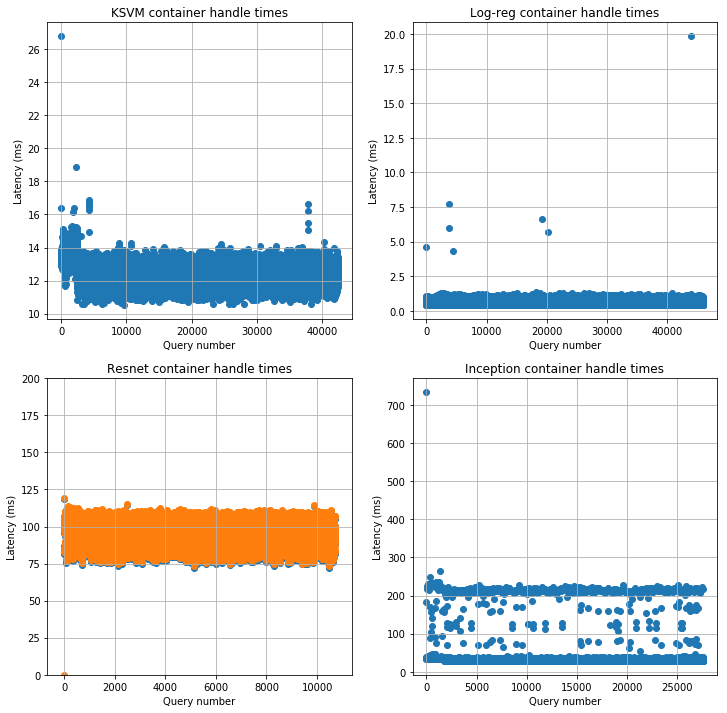

In [294]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.grid(True)
plt.title("KSVM container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.scatter(np.arange(ksvm_handle_times.shape[0]), ksvm_handle_times)
plt.subplot(2,2,2)
plt.grid(True)
plt.title("Log-reg container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.scatter(np.arange(log_reg_handle_times.shape[0]), log_reg_handle_times)
plt.subplot(2,2,3)
plt.grid(True)
plt.ylim([0,200])
plt.title("Resnet container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.scatter(np.arange(resnet_handle_times.shape[0]), resnet_handle_times)
plt.scatter(np.arange(resnet_loop_times.shape[0]), resnet_loop_times, alpha=1)
plt.subplot(2,2,4)
plt.grid(True)
plt.title("Inception container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.scatter(np.arange(inception_handle_times.shape[0]), inception_handle_times)


In [342]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.scatter(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

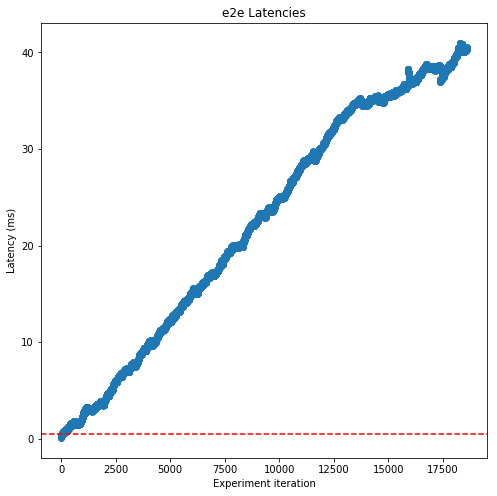

In [344]:
plot_e2e_lats(half_ID1_500_hollistic)

In [309]:
def plot_mean_effective_batchsizes(cached_extraction):
    plt.figure(figsize=(8,8))
    plt.title("Mean effective batchsizes")
    batchsizes = cached_extraction["mean_batch_sizes"]
    for key in batchsizes.keys():
        plt.scatter(np.arange(len(batchsizes[key])), batchsizes[key], label=key)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Mean effective batchsize")
    plt.legend()
    plt.grid(True)

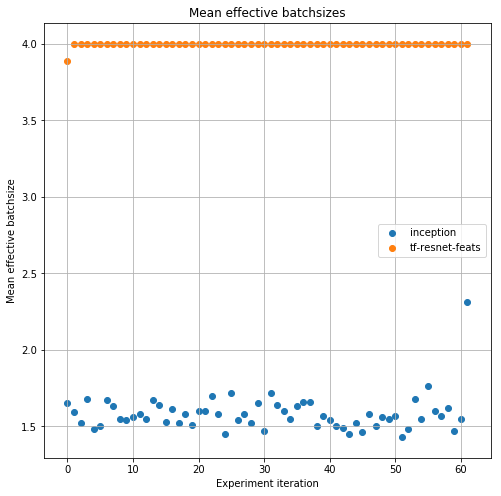

In [345]:
plot_mean_effective_batchsizes(half_ID1_500_hollistic)

In [311]:
def plot_e2e_thrus(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Throughputs")
    thrus = cached_extractions["e2e_thrus"]
    plt.scatter(np.arange(len(thrus)), thrus)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Throughput (queries per second)")
    label = cached_extractions["used_delay_process"] + cached_extractions["used_delay_batchsize"]
    plt.axhline(y=1/float(cached_extractions["used_delay_value"]), color="red", linestyle='--', label=label)
    plt.grid(True)
    plt.legend()

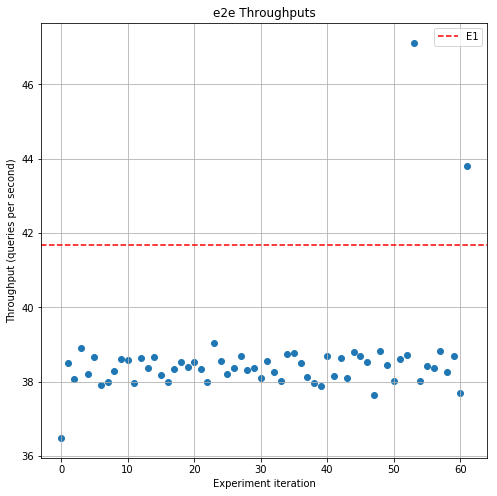

In [346]:
plot_e2e_thrus(half_ID1_500_hollistic)